# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [518]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [519]:
pd.set_option('display.max_rows', 50)

In [520]:
pd.set_option('display.max_columns', None)

### 데이터 읽어오기


In [1181]:
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv("data/train.csv")
train_data

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
0          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
2          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
3          IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
4          IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
...            ...               ...               ...              ...   
40501      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40502      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40503      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
40504      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   
40505      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
0        4F1XA938-1                  1                  OK   
1        3KPM0016-2                  1                  OK   
2        4E1X9167-1                  1                  OK   
3        3K1X0057-1                  1                  OK   
4        3HPM0007-1                  1                  OK   
...             ...                ...                 ...   
40501    3J1XF434-2                  1                  OK   
40502    4E1XC796-1                  1                  OK   
40503    4C1XD438-1                  1                  OK   
40504    3I1XA258-1                  1                  OK   
40505    3G1XA501-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
1                                       240.0   
2                                      1000.0   
3                                      1000.0   
4                                       240.0   
...                                       ...   
40501                                   240.0   
40502                                  1000.0   
40503                                   240.0   
40504                                  1000.0   
40505                                   240.0   

       CURE END POSITION X Unit Time_Dam  CURE END POSITION X Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN                                  NaN   
2                                    NaN                                  NaN   
3                                    NaN                                  NaN   
4                                    NaN                                  NaN   
...                                  ...                                  ...   
40501                                NaN                                  NaN   
40502                                NaN                                  NaN   
40503                                NaN                                  NaN   
40504                                NaN                                  NaN   
40505                                NaN                                  NaN   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                         2.5   
2                                        12.5   
3                                        12.5   
4                                         2.5   
...                                       ...   
40501                                     2.5   
40502                                    12.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Z Unit Time_Dam  CURE END POSITION Z Judge Value_Dam  \
0                                    NaN                                  NaN   
1                                    NaN       

## 2. EDA

#### 행 밀린거 복구

In [1182]:
def pre(data):
    data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']=data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna('NO')
    data['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave']=data['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'].fillna('NO')
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace({'OK': np.nan}, inplace=True)
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace({'OK': np.nan}, inplace=True)
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace({'OK': np.nan}, inplace=True)

    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].replace({'OK': np.nan}, inplace=True)
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'].replace({'OK': np.nan}, inplace=True)
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'].replace({'OK': np.nan}, inplace=True)

    data.dropna(axis=1, how='all', inplace=True)

    # THICKNESS 1 Collect Result_Dam 값이 0이 아닌 값들을 식별
    mask = data['THICKNESS 1 Collect Result_Dam'] != 0

    # 밀린 열의 시작점과 끝점 정의
    start_cols = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_'
    end_cols = 'WorkMode Collect Result_'  # 밀림이 발생한 마지막 열까지의 이름을 넣어야 합니다.

    for type in ['Dam', 'Fill1', 'Fill2']:
        start_col=start_cols+type
        end_col=end_cols+type
        # 밀린 열의 인덱스를 찾습니다.
        start_idx = data.columns.get_loc(start_col)
        end_idx = data.columns.get_loc(end_col) + 1  # 마지막 열 포함

        # 비정상적인 행들에서 밀린 열들만 선택하여 앞으로 이동
        shifted_part = data.loc[mask, data.columns[start_idx:end_idx]].shift(axis=1, periods=-1)

        # 이동된 값을 원래 데이터프레임에 반영
        data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part
        
    data['WorkMode Collect Result_Dam'].fillna(7, inplace=True)
    data['WorkMode Collect Result_Fill1'].fillna(7, inplace=True)
    data['WorkMode Collect Result_Fill2'].fillna(0, inplace=True)

    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype('float64')
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype('float64')
    data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype('float64')

    data.dropna(axis=1, how='all', inplace=True)

    return data

train_data=pre(train_data)

C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part
C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part


In [1003]:
df=train_data.copy()

In [897]:
train_data=train_data[(train_data['Equipment_Dam'].str[-2:] == train_data['Equipment_Fill1'].str[-2:]) & 
                      (train_data['Equipment_Dam'].str[-2:] == train_data['Equipment_Fill2'].str[-2:])]

train_data=train_data[(train_data['Production Qty Collect Result_Dam']==train_data['Production Qty Collect Result_Fill1']) &
                      (train_data['Production Qty Collect Result_Dam']==train_data['Production Qty Collect Result_Fill2'])]

In [1004]:
unique_cols = list(train_data.columns)  # 원래 열 순서를 유지하기 위해 리스트로 변환
duplicate_pairs = []  # 중복된 열을 저장할 리스트

for col1 in train_data.columns:
    if col1 in unique_cols:
        for col2 in unique_cols.copy():
            if col1 != col2:
                unique_pairs = train_data[[col1, col2]].drop_duplicates()
                if len(unique_pairs) == train_data[col1].nunique() and train_data[col1].nunique() == train_data[col2].nunique():
                    unique_cols.remove(col2)  # 열 순서를 유지하면서 col2를 제거
                    duplicate_pairs.append((col1, col2))  # 중복된 열 쌍을 추가


# 중복된 열 출력
print("Duplicate columns based on patterns:")
for pair in duplicate_pairs:
    print(f"Column '{pair[1]}' is a duplicate of '{pair[0]}'")

Duplicate columns based on patterns:
Column 'Process Desc._Dam' is a duplicate of 'Wip Line_Dam'
Column 'Insp. Seq No._Dam' is a duplicate of 'Wip Line_Dam'
Column 'Insp Judge Code_Dam' is a duplicate of 'Wip Line_Dam'
Column 'CURE STANDBY POSITION X Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'CURE STANDBY POSITION Z Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'CURE STANDBY POSITION Θ Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'CURE START POSITION Z Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'HEAD Standby Position X Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'HEAD Standby Position Y Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'HEAD Standby Position Z Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'Head Clean Position X Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'Head Clean Position Y Collect Result_Dam' is a duplicate of 'Wip Line_Dam'
Column 'Head Purge Pos

In [921]:
train_data=train_data[unique_cols]

In [922]:
train_data=train_data.loc[:, train_data.nunique()>1]

## 3. 모델링

### autoencoder

In [655]:
test=pd.read_csv('data/test.csv')
test.drop('Set ID', axis=1, inplace=True)
pre(test)
test=test[unique_cols[:-1]]
test=test.loc[:, test.nunique()>1]

C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.054  0.     0.    ...  0.     0.     0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part
C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[85. 85. 85. ... 85. 85. 85.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part


In [656]:
from sklearn.preprocessing import LabelEncoder
train_data['target']=train_data['target'].map({'Normal':0, 'AbNormal':1})

label_encoders = {}
for column in train_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    train_data[column] = label_encoders[column].fit_transform(train_data[column])
    
    # 테스트 데이터 변환 시 예외 처리
    test[column] = test[column].apply(lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1)

In [692]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('target', axis=1), train_data['target'], test_size=0.2, random_state=RANDOM_STATE, stratify=train_data['target'])

In [693]:
normal_dataset = torch.tensor(X_train[y_train==0].values)
anomal_dataset = torch.tensor(X_train[y_train==1].values)

real_test = torch.tensor(test.values).float()

X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.reset_index(drop=True))

train_size, test_size = round(len(normal_dataset)*0.7), round(len(anomal_dataset)*0.3)

train_dataset = normal_dataset[:train_size]
anomal_train= anomal_dataset[:test_size]
train_dataset = torch.cat((train_dataset, anomal_train), dim=0).float()

test_dataset = normal_dataset[train_size:]
anomal_test = anomal_dataset[test_size:]
test_dataset = torch.cat((test_dataset, anomal_test), dim=0).float()
test_answer = torch.tensor([False]*len(normal_dataset[train_size:])+[True]*len(anomal_test))


batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [694]:
class Encoder(Model):

    def __init__(self, seq_length, latent_dim):
        super(Encoder, self).__init__()

        self.h1 = LSTM(128, return_sequences=True)  # (seq_len, input_dim) -> (seq_len, 128))
        self.h2 = LSTM(latent_dim, return_sequences=False) # (seq_len , 128) -> (latent_dim)
        self.h3 = RepeatVector(seq_length) # (latent_dim) -> (seq_length, latent_dim)

    def call(self, x):
        x = self.h1(x)
        z = self.h2(x)
        z_rep = self.h3(z)

        return z, z_rep
    
class Decoder(Model):

    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()

        self.h1 = LSTM(latent_dim, return_sequences=True) # (seq_length, latent_dim) -> (seq_len, input_dim)
        self.h2 = LSTM(128, return_sequences=True) # (seq_len, input_dim) -> (seq_length, 128)
        self.h3 = TimeDistributed(Dense(input_dim)) # (seq_length, 128) -> (seq_length, input_dim)

    def call(self, x):
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)

        return x


class LstmAE(Model):

    def __init__(self, seq_length, input_dim, latent_dim):
        super(LstmAE, self).__init__()

        self.encoder = Encoder(seq_length, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def call(self, x):
        z, z_rep = self.encoder(x)
        decoded = self.decoder(z_rep)

        return decoded

In [782]:
def train(model, Loss, optimizer, num_epochs):
  train_loss_arr = []
  test_loss_arr = []

  best_test_loss = 99999999
  early_stop, early_stop_max = 0., 10000.

  for epoch in range(num_epochs):

    epoch_loss = 0.
    for batch_X in train_loader:
      
      batch_X = batch_X.to(device)
      optimizer.zero_grad()

      # Forward Pass
      model.train()
      outputs = model(batch_X)
      train_loss = Loss(outputs, batch_X)
      epoch_loss += train_loss.data

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

    train_loss_arr.append(epoch_loss / len(train_loader.dataset))

    if epoch % 10 == 0:
      model.eval()

      test_loss = 0.

      for batch_X in test_loader:
        batch_X = batch_X.to(device)

        # Forward Pass
        outputs = model(batch_X)
        batch_loss = Loss(outputs, batch_X)
        test_loss += batch_loss.data

      test_loss = test_loss
      test_loss_arr.append(test_loss)

      if best_test_loss > test_loss:
          best_test_loss = test_loss
          early_stop = 0

          print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f} *'.format(epoch, num_epochs, epoch_loss, test_loss))
      else:
          early_stop += 1
          print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch, num_epochs, epoch_loss, test_loss))   

    if early_stop >= early_stop_max:
        print('early stopping')
        break

In [791]:
AE = AutoEncoder(train_dataset.shape[1], 64, 32)
AE_loss = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE = AE.to(device)

learning_rate = 0.1

AE_optimizer = optim.Adam(AE.parameters(), lr=learning_rate)

train(AE, AE_loss, AE_optimizer, 1000)

Epoch [0/1000], Train Loss: 3804276480.0000, Test Loss: 41142000.0000 *
Epoch [10/1000], Train Loss: 49238016.0000, Test Loss: 24574090.0000 *
Epoch [20/1000], Train Loss: 49235424.0000, Test Loss: 24568104.0000 *
Epoch [30/1000], Train Loss: 49280052.0000, Test Loss: 24554846.0000 *
Epoch [40/1000], Train Loss: 49264868.0000, Test Loss: 24558724.0000
Epoch [50/1000], Train Loss: 49279052.0000, Test Loss: 24570212.0000
Epoch [60/1000], Train Loss: 49247728.0000, Test Loss: 24562438.0000
Epoch [70/1000], Train Loss: 24308964.0000, Test Loss: 12141428.0000 *
Epoch [80/1000], Train Loss: 24315896.0000, Test Loss: 12153593.0000
Epoch [90/1000], Train Loss: 24275448.0000, Test Loss: 12236794.0000
Epoch [100/1000], Train Loss: 24264570.0000, Test Loss: 12127925.0000 *
Epoch [110/1000], Train Loss: 24285422.0000, Test Loss: 12228019.0000
Epoch [120/1000], Train Loss: 24287232.0000, Test Loss: 12113343.0000 *
Epoch [130/1000], Train Loss: 24306928.0000, Test Loss: 12121014.0000
Epoch [140/1000

In [792]:
mean=((train_dataset-AE(train_dataset))**2).mean(dim=0)
sigma=((train_dataset-AE(train_dataset))**2).std(dim=0)

In [793]:
def f1(test_dataset ,test_answer):

    your_tensor=((test_dataset-AE(test_dataset))**2)

    # 1. 텐서에서 평균을 빼고 표준편차로 나눈 절대값 구하기
    normalized = torch.abs((your_tensor - mean) / sigma)

    # 2. 3 이상인 값의 개수 구하기
    count_above_threshold = (normalized >= 3).sum(dim=1)

    # 3. 30개 이상인 인덱스 선택하기
    indices = torch.where(count_above_threshold >= 2)[0]

    fp=len(indices)-test_answer[indices].sum()
    print(len(indices)-test_answer[indices].sum())
    fn=test_answer.sum()-test_answer[indices].sum()
    print(test_answer.sum()-test_answer[indices].sum())
    tp=test_answer[indices].sum()
    print(test_answer[indices].sum())
    p=tp/(tp+fp)
    r=tp/(tp+fn)
    return 2*p*r/(p+r)

In [794]:
f1(test_dataset, test_answer)

tensor(1256)
tensor(1004)
tensor(260)


tensor(0.1871)

In [795]:
f1(X_test, y_test)

tensor(1052)
tensor(371)
tensor(80)


tensor(0.1011)

In [788]:
my_tensor=((real_test-AE(real_test))**2)

# 1. 텐서에서 평균을 빼고 표준편차로 나눈 절대값 구하기
normalized = torch.abs((my_tensor - mean) / sigma)

# 2. 3 이상인 값의 개수 구하기
count_above_threshold = (normalized >= 1).sum(dim=1)

# 3. 30개 이상인 인덱스 선택하기
indices = torch.where(count_above_threshold >= 20)[0]

In [789]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")

df_sub['target'] = 'Normal'

df_sub.loc[indices.numpy(), "target"]='AbNormal'

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [790]:
df_sub['target'].value_counts()

target
Normal      13919
AbNormal     3442
Name: count, dtype: int64

In [705]:
df_sub.loc[index1, 'target']

64       AbNormal
562        Normal
1460       Normal
1530       Normal
1892     AbNormal
2505       Normal
2710     AbNormal
3457       Normal
3682       Normal
3732     AbNormal
4928     AbNormal
4932       Normal
6092     AbNormal
7001       Normal
7287       Normal
7666       Normal
7836       Normal
8253     AbNormal
8898       Normal
10989      Normal
12439      Normal
12585    AbNormal
12844    AbNormal
14756    AbNormal
15180      Normal
15406      Normal
15811      Normal
15964    AbNormal
Name: target, dtype: object

### KNN

In [306]:
k_data=train_data.copy()

In [307]:
from sklearn.preprocessing import LabelEncoder
k_data['target']=k_data['target'].map({'Normal':0, 'AbNormal':1})

label_encoders = {}
for column in k_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    k_data[column] = label_encoders[column].fit_transform(k_data[column])

In [308]:
from sklearn.preprocessing import StandardScaler

# 수치형 열만 선택
numeric_columns = k_data.columns[:-1]

# RobustScaler 초기화
scaler = StandardScaler()

# 수치형 열에 대해 스케일링 적용
k_data[numeric_columns] = scaler.fit_transform(k_data[numeric_columns])

In [550]:
k_data

Equipment_Dam  Model.Suffix_Dam  Workorder_Dam  \
0          -0.786465          2.860670       1.908275   
1          -0.786465          2.860670      -0.133224   
2           1.271513         -0.373821       1.537093   
3           1.271513         -0.373821      -0.307898   
4          -0.786465         -0.373821      -0.902880   
...              ...               ...            ...   
40501      -0.786465         -0.373821      -0.378859   
40502       1.271513         -0.373821       1.831855   
40503      -0.786465         -0.373821       1.269624   
40504       1.271513         -0.373821      -0.782792   
40505      -0.786465         -0.373821      -1.426901   

       CURE SPEED Collect Result_Dam  \
0                           2.677436   
1                          -0.395835   
2                           1.140801   
3                          -0.395835   
4                          -0.395835   
...                              ...   
40501                      -0.395835   
40502                       2.677436   
40503                       2.677436   
40504                      -0.395835   
40505                      -0.395835   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                          1.040032   
1                                         -0.961562   
2                                          1.040032   
3                                         -0.961562   
4                                         -0.961562   
...                                             ...   
40501                                     -0.961562   
40502                                      1.040032   
40503                                      1.040032   
40504                                     -0.961562   
40505                                     -0.961562   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                               0.167478     
1                                               1.877205     
2                                               0.114049     
3                                               1.877205     
4                                              -1.221675     
...                                                  ...     
40501                                           0.728482     
40502                                           0.167478     
40503                                          -0.019523     
40504                                          -1.221675     
40505                                          -1.248389     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                               0.771295     
1                                              -0.983684     
2                                               0.821437     
3                                               0.771295     
4                                              -0.983684     
...                                                  ...     
40501                                          -0.933542     
40502                                           0.821437     
40503                                           0.671010     
40504                                          -0.983684     
40505                                          -1.485107     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                               0.116947     
1                                               1.885120     
2                                               0.116947     
3                                               1.885120     
4                                              -1.249369     
...                                                  ...     
40501                                           0.733128     
40502                                           0.116947     
40503                                           0.009785     
40504                                          -1.222578     
40505   

In [556]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# 1. 데이터 분리 (이미 라벨 인코딩 및 스케일링이 완료되었다고 가정)
X = k_data.drop('target', axis=1).values  # 입력 데이터
y = k_data['target'].values  # 타겟 변수

# train_test_split을 사용하여 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.metrics import f1_score

def knn_predict(X_train, y_train, X_test, k=3):
    predictions = []
    
    for test_point in X_test:
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        majority_vote = mode(k_nearest_labels).mode
        predictions.append(majority_vote)
    
    return np.array(predictions)

def find_best_k(X_train, y_train, X_test, y_test, k_values):
    best_f1 = 0
    best_k = k_values[0]
    
    for k in k_values:
        y_pred = knn_predict(X_train, y_train, X_test, k)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        
        print(f"k={k}, F1 Score: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_k = k
    
    return best_k, best_f1

# k 값을 1부터 20까지 시도
k_values = range(1, 21)
best_k, best_f1 = find_best_k(X_train, y_train, X_test, y_test, k_values)

print(f"Best k: {best_k}, Best F1 Score: {best_f1:.4f}")

KeyboardInterrupt: 

### 스케일링

In [180]:
col_name=[]
for col in train_data.columns:
    if col=='target':
        col_name.append(col)
        continue
    col_name.append(str(col)+' 2')

In [1183]:
def scale(data, scaler, type='train'):
    # 데이터 프레임 생성
    scaled_data = data.copy()

    for col in data.columns[data.columns.str.contains('PalletID')|data.columns.str.contains('Qty')]:
        data[col]=data[col].astype(str)
        scaled_data[col]=scaled_data[col].astype(str)

    # 실수형 변수만 선택
    numeric_features = data.select_dtypes(include=['float64', 'int64'])

    # 스케일러 적용
    if type == 'train':
        scaled_numeric_features = scaler.fit_transform(numeric_features)
    else:
        scaled_numeric_features = scaler.transform(numeric_features)

    # 스케일링된 데이터를 데이터프레임으로 변환 (원본 인덱스와 동일하게 설정)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_features, index=data.index, columns=numeric_features.columns)

    # 스케일링된 데이터프레임을 원본 데이터에 업데이트
    scaled_data.update(scaled_numeric_df)
    
    if type == 'train':
        return scaled_data, scaler
    else:
        return scaled_data

train_data, scaler=scale(train_data, StandardScaler(), 'train')

### 데이터 분할


In [1845]:
RANDOM_STATE=42

In [1847]:
X_train, y_train = train_data[col_list], train_data['target']
# X_train, X_test, y_train, y_test = train_test_split(train_data.drop('target', axis=1), train_data['target'], test_size=0.1, random_state=RANDOM_STATE, stratify=train_data['target'])
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)

In [1700]:
# 변수 중요도 추출
feature_importances = model2.get_feature_importance()

# 중요도 상위 20개 변수만 추출
top_features = sorted(zip(feature_importances, col), reverse=True)[:40]

### 변수 랜덤 선택

In [1706]:
resample(X_train[[col for _, col in top_features]].columns, replace=False, n_samples=20)

Index(['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       '3rd Pressure Collect Result_AutoClave',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
       'Dispense Volume(Stage2) Collect Result_Fill1',
       'Production Qty Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
       'Model.Suffix_Dam', 'Dispense Volume(Stage3) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Head Purge Position Z Collect Result_Fill1',
       'Receip No Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
       'Machine Tact time Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Chamber Temp. Collect Result_AutoClave',
 

In [1707]:
from sklearn.utils import resample
from catboost import CatBoostClassifier
from collections import Counter

# y_resampled의 클래스 비율 계산
class_counts = y_train.value_counts()
total_samples = len(y_train)
col_dict={}

# 각 클래스의 가중치 계산 (클래스 수가 많을 경우 대비하여 보통의 방식을 사용)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

class_weights['AbNormal'] = class_weights['AbNormal']/1.7

def ensemble_catboost(X_train, y_train, X_test, y_test, num_models=10):
    predictions = np.empty((X_test.shape[0], num_models), dtype=object)
    valid_model_count = 0
    selected_columns_list = []
    
    for i in range(num_models):
        # 1. 무작위로 변수 선택 (예: 50% 변수 선택)
        selected_columns = resample(X_train[[col for _, col in top_features]].columns, replace=False, n_samples=20)
        print(selected_columns)
        col_dict[i]=selected_columns
        X_train_subset = X_train[selected_columns]
        X_test_subset = X_test[selected_columns]
        categorical_features_indices = list(X_train_subset.select_dtypes(include=['object']).columns)
        
        # 2. CatBoost 모델 학습
        model = CatBoostClassifier(
            iterations=300,
            learning_rate=0.1,
            depth=6,
            l2_leaf_reg=3,
            random_strength=1,
            bagging_temperature=0.5,
            loss_function='Logloss',
            eval_metric='F1',
            class_weights=class_weights,
            cat_features=categorical_features_indices,
            random_seed=RANDOM_STATE,
            verbose=100
        )
        model.fit(X_train_subset, y_train, eval_set=(X_test_subset, y_test), use_best_model=True)
        
        # 3. 실제 사용된 iteration 확인 및 학습 조건 확인
        best_iteration = model.get_best_iteration()
        if best_iteration >= 50 and f1_score(model.predict(X_test_subset), y_test, pos_label='AbNormal')>0.185:
            pred = model.predict(X_test_subset)
            predictions[:, valid_model_count] = pred
            selected_columns_list.extend(selected_columns)  # 최종적으로 선택된 모델의 열들을 리스트에 추가
            valid_model_count += 1
        
            print(confusion_matrix(y_test, pred))
        print(f1_score(model.predict(X_test_subset), y_test, pos_label='AbNormal'))

        # 열 선택 빈도 출력
        print("Column selection frequency:")
        for column, count in Counter(selected_columns_list).items():
            print(f"{column}: {count} times")

    # 4. 열들의 선택 빈도 계산
    column_counts = Counter(selected_columns_list)
    print("Column selection counts:", column_counts)
    
    # 결과 배열의 유효 열만 반환
    if valid_model_count > 0:
        return predictions[:, :valid_model_count], column_counts
    else:
        return np.empty((X_test.shape[0], 0), dtype=object), column_counts

# 앙상블 CatBoost 모델 예측
y_pred, column_counts = ensemble_catboost(X_train, y_train, X_test, y_test, num_models=20)

# 열 선택 빈도 출력
print("Column selection frequency:")
for column, count in column_counts.items():
    print(f"{column}: {count} times")

Index(['Dispense Volume(Stage3) Collect Result_Dam',
       'Head Purge Position Z Collect Result_Fill1',
       '1st Pressure Collect Result_AutoClave',
       'Production Qty Collect Result_Fill2',
       'Machine Tact time Collect Result_Fill2',
       'Production Qty Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'Machine Tact time Collect Result_Dam',
       '3rd Pressure Collect Result_AutoClave',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'Workorder_Dam', 'Chamber Temp. Collect Result_AutoClave',
       'Receip No Collect Result_Fill2',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'Machine Tact time Collect Result_Fill1',
       'Dispense Volume(Stage1) Collect Result_Dam',
       'PalletID Coll

In [1717]:
col_list=[]
for column, count in column_counts.items():
    if count >= 2:
        col_list.append(column)
col_list

['Dispense Volume(Stage3) Collect Result_Dam',
 'Head Purge Position Z Collect Result_Fill1',
 '1st Pressure Collect Result_AutoClave',
 'Production Qty Collect Result_Fill2',
 'Machine Tact time Collect Result_Fill2',
 'Production Qty Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
 'Machine Tact time Collect Result_Dam',
 '3rd Pressure Collect Result_AutoClave',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'Workorder_Dam',
 'Chamber Temp. Collect Result_AutoClave',
 'Receip No Collect Result_Fill2',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
 'Machine Tact time Collect Result_Fill1',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'PalletID Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(S

In [1862]:
categorical_features_indices = list(X_train[col_list].select_dtypes(include=['object']).columns)

# y_resampled의 클래스 비율 계산
class_counts = y_train.value_counts()
total_samples = len(y_train)

# 각 클래스의 가중치 계산 (클래스 수가 많을 경우 대비하여 보통의 방식을 사용)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

class_weights['AbNormal'] = class_weights['AbNormal']/1.77

# 2. CatBoost 모델 학습
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=0.5,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=class_weights,
    cat_features=categorical_features_indices,
    random_seed=RANDOM_STATE,
    verbose=100
)
model.fit(X_train[col_list], y_train, use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.0915134	total: 109ms	remaining: 32.4s
100:	learn: 0.3424095	total: 16.7s	remaining: 32.9s
200:	learn: 0.3476170	total: 32.3s	remaining: 15.9s
299:	learn: 0.3571691	total: 51.7s	remaining: 0us


In [1874]:
final_predictions = model.predict(X_train[col_list])
print(confusion_matrix(final_predictions, y_train))
print(classification_report(y_train, final_predictions))
print(f1_score(final_predictions, y_train, pos_label='AbNormal'))

[[  628  1558]
 [ 1722 36598]]
              precision    recall  f1-score   support

    AbNormal       0.29      0.27      0.28      2350
      Normal       0.96      0.96      0.96     38156

    accuracy                           0.92     40506
   macro avg       0.62      0.61      0.62     40506
weighted avg       0.92      0.92      0.92     40506

0.27689594356261027


In [1875]:
final_predictions = model.predict(X_test[col_list])
print(confusion_matrix(final_predictions, y_test))
print(classification_report(y_test, final_predictions))
print(f1_score(final_predictions, y_test, pos_label='AbNormal'))

[[  65  148]
 [ 170 3668]]
              precision    recall  f1-score   support

    AbNormal       0.31      0.28      0.29       235
      Normal       0.96      0.96      0.96      3816

    accuracy                           0.92      4051
   macro avg       0.63      0.62      0.62      4051
weighted avg       0.92      0.92      0.92      4051

0.29017857142857145


In [1864]:
test=pd.read_csv('data/test.csv')
pre(test)
test=scale(test, scaler,'test')
test=test[unique_cols[:-1]]

C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.054  0.     0.    ...  0.     0.     0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part
C:\Users\horri\AppData\Local\Temp\ipykernel_10384\828193697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[85. 85. 85. ... 85. 85. 85.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, data.columns[start_idx:end_idx]] = shifted_part


In [1865]:
real_pred=model.predict(test[col_list])

In [1866]:
df_sub

Set ID  target
0      0001be084fbc4aaa9d921f39e595961b  Normal
1      0005bbd180064abd99e63f9ed3e1ac80  Normal
2      000948934c4140d883d670adcb609584  Normal
3      000a6bfd02874c6296dc7b2e9c5678a7  Normal
4      0018e78ce91343678716e2ea27a51c95  Normal
...                                 ...     ...
17356  ffea508b59934d689b540f95eb3fa730  Normal
17357  ffed8923c8a448a98afc641b770be153  Normal
17358  fff1e73734da40adbe805359b3efb462  Normal
17359  fff8e38bdd09470baf95f71e92075dec  Normal
17360  fffa83e0a13d4c2db4fd8bf905b517d4  Normal

[17361 rows x 2 columns]

In [1877]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = real_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [1878]:
df_sub['target'].value_counts()

target
Normal      16378
AbNormal      983
Name: count, dtype: int64

In [1871]:
len(df_sub)*0.06

1041.6599999999999

In [1872]:
index4=[498, 3687, 3875, 5702, 5886, 10191, 10345, 12386, 13349]

In [1876]:
df_sub.loc[index2, 'target'].value_counts()

target
Normal      48
AbNormal     5
Name: count, dtype: int64

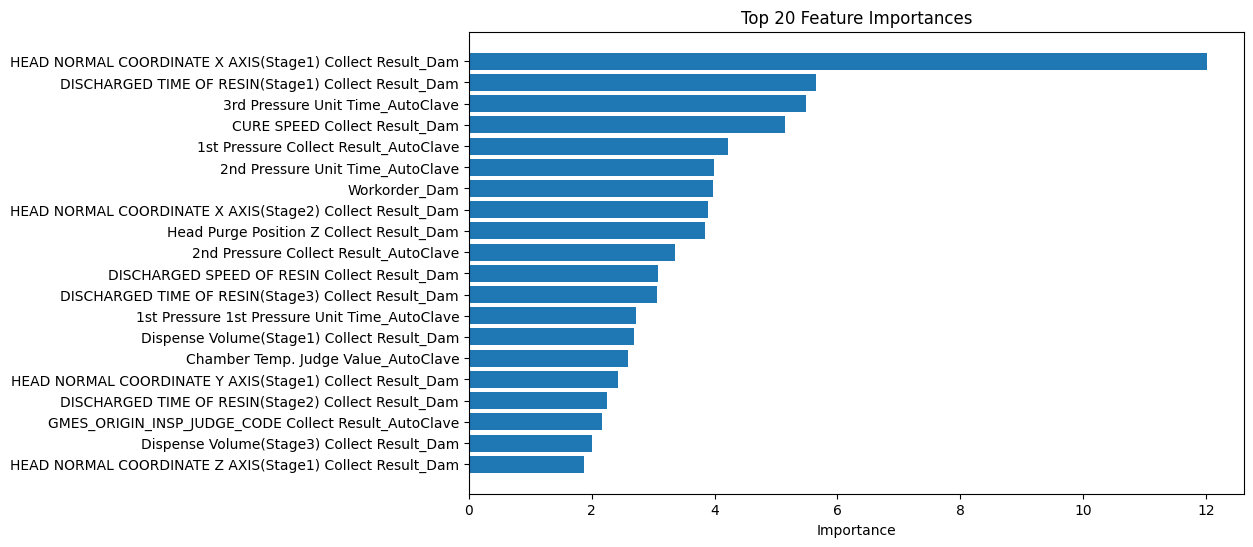

In [1795]:
import matplotlib.pyplot as plt

# 변수 중요도 추출
feature_importances = model.get_feature_importance()

# 중요도 상위 20개 변수만 추출
top_features = sorted(zip(feature_importances, col), reverse=True)[:20]

# 변수명과 중요도를 각각 리스트로 추출
top_importances = [imp for imp, _ in top_features]
top_names = [name for _, name in top_features]

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_names, top_importances)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 중요도 순으로 내림차순 정렬
plt.show()

In [1731]:
final_predictions = []
for row in y_pred:
    abnormal_count = np.sum(row == 'AbNormal')
    if abnormal_count >= 5:
        final_predictions.append('AbNormal')
    else:
        final_predictions.append('Normal')

# F1 Score 계산
f1 = f1_score(y_test, final_predictions, pos_label='AbNormal')
print(f"Ensemble CatBoost F1 Score: {f1:.4f}")

Ensemble CatBoost F1 Score: 0.2076


In [1732]:
sum_list=[]
for row in y_pred:
    abnormal_count = np.sum(row == 'AbNormal')
    sum_list.append(abnormal_count)

sum_list


[0,
 0,
 0,
 0,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 7,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 1,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 7,


In [1733]:
print(confusion_matrix(final_predictions, y_test))
print(classification_report(y_test, final_predictions))

[[ 107  454]
 [ 363 7178]]
              precision    recall  f1-score   support

    AbNormal       0.19      0.23      0.21       470
      Normal       0.95      0.94      0.95      7632

    accuracy                           0.90      8102
   macro avg       0.57      0.58      0.58      8102
weighted avg       0.91      0.90      0.90      8102



### 데이터 증강

#### 언더

In [321]:
normal_ratio = 10
df_normal = X_train[y_train == 'Normal']
df_abnormal = X_train[y_train == 'AbNormal']

df_normal=pd.concat([df_normal, y_train[y_train=='Normal']], axis=1)
df_abnormal=pd.concat([df_abnormal, y_train[y_train=='AbNormal']], axis=1)

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_resampled = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
X_train=df_resampled.drop('target', axis=1)
y_train=df_resampled['target']

y_train.value_counts()

  Total: Normal: 14100, AbNormal: 1410


target
0    7050
1    1410
Name: count, dtype: int64

#### 보더라인

In [322]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.neighbors import NearestNeighbors

numeric_features = X_train.select_dtypes(include=['float64', 'int64'])

# BorderlineSMOTE 적용
smote = BorderlineSMOTE(random_state=RANDOM_STATE, sampling_strategy=0.3)
X_resampled_numeric, y_resampled = smote.fit_resample(numeric_features, y_train)

# 원래 데이터와 오버샘플링된 데이터의 수 차이 계산
n_new_samples = len(X_resampled_numeric) - len(numeric_features)

# Nearest Neighbors 모델로 가장 가까운 이웃 찾기
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(numeric_features)
nearest_neighbors = neighbors.kneighbors(X_resampled_numeric[-n_new_samples:], return_distance=False)

# 이웃한 범주형 변수 할당
categorical_features = X_train.select_dtypes(include=['object'])
new_categorical_features = categorical_features.iloc[nearest_neighbors.flatten()]

# 새로 생성된 범주형 변수와 숫자형 변수를 결합
X_resampled = pd.concat([
    pd.DataFrame(X_resampled_numeric, columns=numeric_features.columns),
    pd.concat([categorical_features, new_categorical_features], ignore_index=True)
], axis=1)

X_train=X_resampled[X_train.columns]
y_train=y_resampled

### Cat Boost

In [1008]:
from catboost import CatBoostClassifier, Pool

col=train_data.columns[(train_data.columns.str.contains('Auto'))|(train_data.columns.str.contains('Dam'))|(train_data.columns.str.contains('Fill1'))]
col=X_train.columns
categorical_features_indices = list(X_train[col].select_dtypes(include=['object']).columns)

# y_resampled의 클래스 비율 계산
class_counts = y_train.value_counts()
total_samples = len(y_train)

# 각 클래스의 가중치 계산 (클래스 수가 많을 경우 대비하여 보통의 방식을 사용)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

class_weights['AbNormal'] = class_weights['AbNormal']/1.7

# CatBoost 모델 정의
model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=0.5,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=class_weights,  # 계산한 클래스 가중치 적용
    cat_features=categorical_features_indices,
    random_seed=RANDOM_STATE,
    verbose=100
)

# 모델 학습
model.fit(X_train[col], y_train, eval_set=(X_val[col], y_val), use_best_model=True)

# 기존 모델로 예측 확률 계산
y_pred_proba = model.predict_proba(X_train[col])[:, 1]

# 낮은 임계값(예: 0.3)을 사용하여 더 많은 하드 네거티브 케이스 선택
threshold = 0.5
hard_negative_cases = X_train[(y_train == 'AbNormal') & (y_pred_proba > threshold)]
hard_negative_labels = y_train[(y_train == 'AbNormal') & (y_pred_proba > threshold)]

# 원본 학습 데이터와 결합
X_train_hard = pd.concat([X_train[col], hard_negative_cases])
y_train_hard = pd.concat([y_train, hard_negative_labels])

# 모델 재학습
# model.fit(X_train_hard, y_train_hard, eval_set=(X_val[col], y_val), use_best_model=True)

0:	learn: 0.2345922	test: 0.2431377	best: 0.2431377 (0)	total: 81.7ms	remaining: 57.1s
100:	learn: 0.1980978	test: 0.1649886	best: 0.2431377 (0)	total: 9.99s	remaining: 59.2s
200:	learn: 0.2976032	test: 0.2785557	best: 0.2790519 (176)	total: 22.9s	remaining: 56.8s
300:	learn: 0.3505398	test: 0.3279099	best: 0.3279099 (300)	total: 32.3s	remaining: 42.8s
400:	learn: 0.3909699	test: 0.3630189	best: 0.3632570 (394)	total: 41.3s	remaining: 30.8s
500:	learn: 0.4169346	test: 0.3716187	best: 0.3719177 (492)	total: 53.2s	remaining: 21.1s
600:	learn: 0.4400338	test: 0.3887869	best: 0.3912728 (593)	total: 1m 8s	remaining: 11.2s
699:	learn: 0.4595387	test: 0.3975676	best: 0.4001467 (664)	total: 1m 20s	remaining: 0us

bestTest = 0.4001466659
bestIteration = 664

Shrink model to first 665 iterations.


In [1606]:
# 예측 확률 계산
y_pred_proba1 = model2.predict_proba(X_test[col])[:, 1]

y_pred_proba2 = model3.predict_proba(X_test[col])[:, 1]

# 임계값 조정
threshold1 = 0.518

threshold2 = 0.775

y_pred = np.array(['AbNormal' if (i > threshold1)|(j > threshold2) else 'Normal' for i, j in zip(y_pred_proba1, y_pred_proba2)])

In [1607]:
f1_score(y_val, model3.predict(X_val[col]), pos_label='AbNormal')

0.10977461170150647

In [1608]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm=confusion_matrix(y_test, y_pred)
print('혼동행렬\n', cm)
p_score=precision_score(y_test, y_pred, pos_label='AbNormal')
r_score=recall_score(y_test, y_pred, pos_label='AbNormal')
f_score=f1_score(y_test, y_pred, pos_label='AbNormal')
print('precision: ', p_score)
print('recall: ', r_score)
print('f1 score: ', f_score)

혼동행렬
 [[  98  372]
 [ 379 7253]]
precision:  0.20545073375262055
recall:  0.20851063829787234
f1 score:  0.20696937697993664


In [1515]:
X_test[(y_pred=='AbNormal')&(y_test=='Normal')]['Workorder_Dam'].value_counts()

Workorder_Dam
3H1X7984-1       19
3G1XC632-1       12
3G1XB045-1       10
4A1XA713-1       10
3G1XA482-1        9
3F1XC781-1        8
3H1X7984-2        8
3G1X8298-2        8
3F1XC600-1        7
3HPXX066-0001     6
3I1XB255-1        5
3G1XC498-1        5
3G1XA501-1        5
3G1XA615-2        5
4B1XE009-1        4
4A1XB338-1        4
3G1XB044-1        4
3I1X9339-2        4
4E1XA654-1        4
3G1X8298-1        4
4E1X9996-1        3
3G1X8297-2        3
3I1X9723-1        3
3M1XH425-1        3
3I1XA992-1        2
3H1X3340-1        2
4F1XA938-1        2
3H1X9881-1        2
3I1XA464-1        1
3H1XE687-1        1
3G1XB176-1        1
3G1XC620-1        1
3G1X8646-1        1
3I1XB112-1        1
3G1XB948-2        1
4A1XA434-1        1
3H1XE357-2        1
3L1X1374-1        1
3M1XF442-1        1
4A1XB977-1        1
Name: count, dtype: int64

In [1313]:
df[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']]

HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam  \
0                                                  550.5          
1                                                  550.3          
2                                                  162.4          
3                                                  162.4          
4                                                  549.0          
...                                                  ...          
40501                                              550.3          
40502                                              163.5          
40503                                              550.6          
40504                                              162.4          
40505                                              549.0          

       HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam  \
0                                                  384.0          
1                                                  377.3          
2                                                 1271.8          
3                                                 1271.8          
4                                                  377.5          
...                                                  ...          
40501                                              377.3          
40502                                             1281.0          
40503                                              377.6          
40504                                             1269.0          
40505                                              377.5          

       HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam  
0                                                 274.51         
1                                                 282.15         
2                                                 274.33         
3                                                 282.15         
4                                                 284.80         
...                                                  ...         
40501                                             282.15         
40502                                             274.33         
40503                                             274.78         
40504                                             282.15         
40505                                             284.80         

[40506 rows x 3 columns]

In [1323]:
test_data=pd.read_csv('data/test.csv')

In [1332]:
train_data['Workorder_Dam'].value_counts().tail(30)

Workorder_Dam
3H1XC430-1       7
3HPXX057-0001    7
4BPM0083-1       6
4C1XJ040-1       6
3K1XA576-2       6
3G1X8647-2       5
3J1XE700-1       5
3G1XB159-1       5
3L1XB234-1       4
4CPM0074-1       4
3LPM0199-1       4
3I1XA274-1       4
3HPXX124-0001    4
4APXX107-0001    4
4E1X7697-1       4
4BPM0087-1       4
4CPM0032-1       4
4E1X9525-1       3
3K1X9887-2       3
3LPM0200-1       3
4BPM0085-1       3
3HPM0062-1       3
4EPM0225-1       3
4A1XC288-1       2
4A1XE569-1       2
4BPM0084-1       2
3FPXX064-0003    2
3H1XB714-1       1
4CPM0166-1       1
3HPM0061-1       1
Name: count, dtype: int64

In [1334]:
df[df['Workorder_Dam']=='3H1XC430-1']['Production Qty Collect Result_Dam']

14227    74
22225    80
24710    73
26779    76
32441    77
33172    78
36502    75
Name: Production Qty Collect Result_Dam, dtype: int64

In [1335]:
test_data[unique_cols].sort_values(['Workorder_Dam', 'Production Qty Collect Result_Dam']).tail(50)

Wip Line_Dam     Equipment_Dam Model.Suffix_Dam Workorder_Dam  \
8712       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-1   
8539       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
10923      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
11604      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
13843      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
3355       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
4243       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
5506       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
8778       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
9119       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
10840      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
16765      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
5997       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
12708      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
14071      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
16086      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
11430      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
2457       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
4324       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
8613       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
1371       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
4517       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
14731      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
15172      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-1   
9345       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
11412      IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
15004      IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
5227       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
10218      IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
10878      IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
4999       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
4314       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
5072       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
7479       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
3015       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
9528       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
5039       IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
16667      IVI-OB6  Dam dispenser #1      AJX75334505    4F1XB758-2   
5311       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
679        IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
11508      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
1739       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
2605       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
14739      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
917        IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
928        IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
7531       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
15964      IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
3570       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   
4556       IVI-OB6  Dam dispenser #2      AJX75334505    4F1XB758-2   

       CURE SPEED Collect Result_Dam  \
8712                             100   
8539                             100   
10923                            100   
11604                            100   
13843                            100   
3355                             100   
4243                             100   
5506                             100   
8778                    

In [1336]:
df.sort_values(['Workorder_Dam', 'Production Qty Collect Result_Dam']).tail(50)

Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
27979      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35688      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1337       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
23231      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
10554      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
9126       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
34475      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
1308       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
15736      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
30254      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
13728      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
6237       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
15740      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
13029      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
26885      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
8242       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
102        IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
9366       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
2337       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
28349      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
9724       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
137        IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
33537      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
1105       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
8555       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
33733      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
28529      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
30573      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
12591      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
36249      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
31792      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
13299      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
29264      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
11971      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
29755      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
13295      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
4620       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
24536      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
5222       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
37685      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
38921      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
39116      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
15355      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
15588      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
36070      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
37634      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
14734      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
28808      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
15323      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334505   
36446      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
27979    4F1XB758-1                  1                  OK   
35688    4F1XB758-1                  1                  

In [1386]:
df[unique_cols]

Wip Line_Dam     Equipment_Dam Model.Suffix_Dam Workorder_Dam  \
0          IVI-OB6  Dam dispenser #1      AJX75334505    4F1XA938-1   
1          IVI-OB6  Dam dispenser #1      AJX75334505    3KPM0016-2   
2          IVI-OB6  Dam dispenser #2      AJX75334501    4E1X9167-1   
3          IVI-OB6  Dam dispenser #2      AJX75334501    3K1X0057-1   
4          IVI-OB6  Dam dispenser #1      AJX75334501    3HPM0007-1   
...            ...               ...              ...           ...   
40501      IVI-OB6  Dam dispenser #1      AJX75334501    3J1XF434-2   
40502      IVI-OB6  Dam dispenser #2      AJX75334501    4E1XC796-1   
40503      IVI-OB6  Dam dispenser #1      AJX75334501    4C1XD438-1   
40504      IVI-OB6  Dam dispenser #2      AJX75334501    3I1XA258-1   
40505      IVI-OB6  Dam dispenser #1      AJX75334501    3G1XA501-1   

       CURE SPEED Collect Result_Dam  \
0                                100   
1                                 70   
2                                 85   
3                                 70   
4                                 70   
...                              ...   
40501                             70   
40502                            100   
40503                            100   
40504                             70   
40505                             70   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                10   
2                                                16   
3                                                10   
4                                                10   
...                                             ...   
40501                                            10   
40502                                            16   
40503                                            16   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.7     
...                                                  ...     
40501                                               17.0     
40502                                               14.9     
40503                                               14.2     
40504                                                9.7     
40505                                                9.6     

       DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam  \
0                                                    8.4     
1                                                    4.9     
2                                                    8.5     
3                                                    8.4     
4                                                    4.9     
...                                                  ...     
40501                                                5.0     
40502                                                8.5     
40503                                                8.2     
40504                                                4.9     
40505                                                3.9     

       DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam  \
0                                                   14.7     
1                                                   21.3     
2                                                   14.7     
3                                                   21.3     
4                                                    9.6     
...                                                  ...     
40501                                               17.0     
40502                    

In [1528]:
df.groupby(['DISCHARGED SPEED OF RESIN Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'Dispense Volume(Stage1) Collect Result_Dam'])['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'].mean()

DISCHARGED SPEED OF RESIN Collect Result_Dam  DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  Dispense Volume(Stage1) Collect Result_Dam
10                                            9.6                                                  0.67                                          284.699854
                                              9.7                                                  0.67                                          284.149265
                                              11.6                                                 0.81                                          284.800000
                                              17.0                                                 1.19                                          282.150000
                                              17.1                                                 1.19                                          282.150000
                                              21.2                            

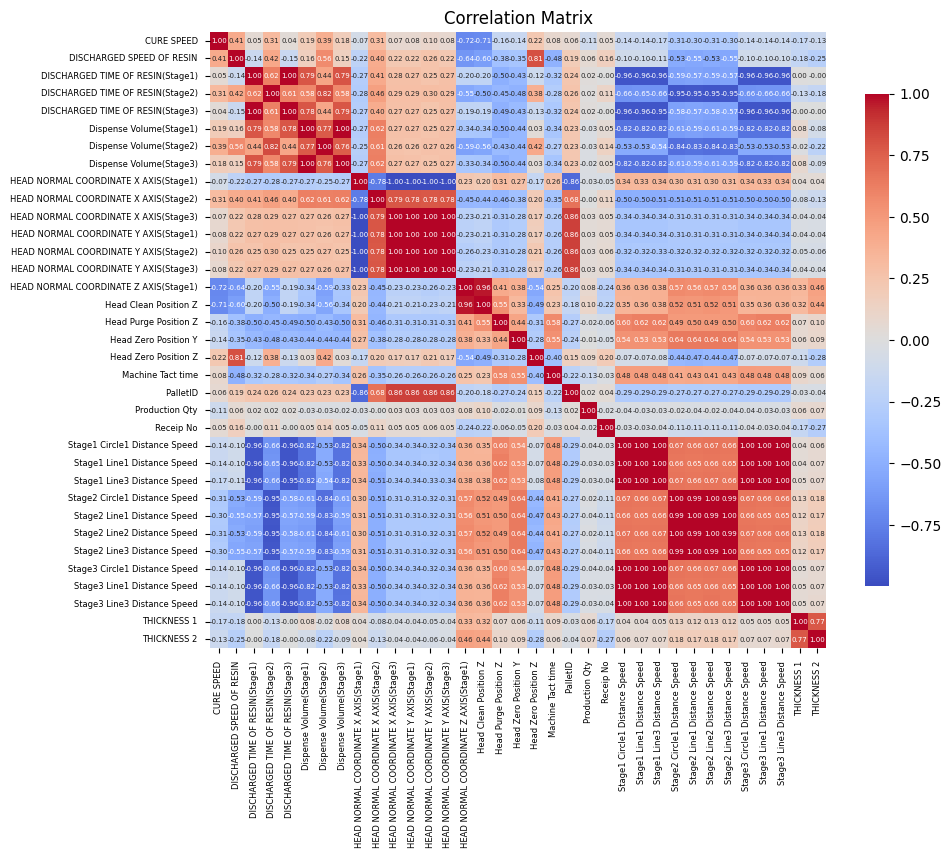

In [1457]:
corr_matrix = df[unique_cols].loc[:,(df[unique_cols].columns.str.contains('Dam'))].select_dtypes(['float64', 'int64']).corr()

corr_matrix.columns=[str(col)[:-18]for col in corr_matrix.columns]
corr_matrix.index=[str(col)[:-18]for col in corr_matrix.index]

# 상관 행렬 플롯
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8},
            annot_kws={"size": 5})


# x축과 y축 레이블의 크기 조정
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.title('Correlation Matrix')
plt.show()

In [1316]:
df[unique_cols].head(50)

Wip Line_Dam     Equipment_Dam Model.Suffix_Dam  Workorder_Dam  \
0       IVI-OB6  Dam dispenser #1      AJX75334505     4F1XA938-1   
1       IVI-OB6  Dam dispenser #1      AJX75334505     3KPM0016-2   
2       IVI-OB6  Dam dispenser #2      AJX75334501     4E1X9167-1   
3       IVI-OB6  Dam dispenser #2      AJX75334501     3K1X0057-1   
4       IVI-OB6  Dam dispenser #1      AJX75334501     3HPM0007-1   
5       IVI-OB6  Dam dispenser #1      AJX75334501     3G1X8297-2   
6       IVI-OB6  Dam dispenser #1      AJX75334501     3M1XH425-1   
7       IVI-OB6  Dam dispenser #2      AJX75334501     4A1XB542-4   
8       IVI-OB6  Dam dispenser #1      AJX75334501     3H1X9883-1   
9       IVI-OB6  Dam dispenser #1      AJX75334501     3G1XD171-2   
10      IVI-OB6  Dam dispenser #2      AJX75334501     4E1X9168-1   
11      IVI-OB6  Dam dispenser #2      AJX75334501     4A1XC343-1   
12      IVI-OB6  Dam dispenser #2      AJX75334501     3L1XA128-1   
13      IVI-OB6  Dam dispenser #2      AJX75334501     3L1X8574-2   
14      IVI-OB6  Dam dispenser #1      AJX75334501     3GPM0070-1   
15      IVI-OB6  Dam dispenser #1      AJX75334501     3G1X4502-2   
16      IVI-OB6  Dam dispenser #1      AJX75334501     3F1X9648-1   
17      IVI-OB6  Dam dispenser #1      AJX75334502     4B1XA868-1   
18      IVI-OB6  Dam dispenser #1      AJX75334501     3L1XB019-1   
19      IVI-OB6  Dam dispenser #1      AJX75334501     4C1X0049-1   
20      IVI-OB6  Dam dispenser #1      AJX75334501     4B1XD472-2   
21      IVI-OB6  Dam dispenser #2      AJX75334501     4B1XD691-1   
22      IVI-OB6  Dam dispenser #1      AJX75334501     3G1XB994-1   
23      IVI-OB6  Dam dispenser #1      AJX75334501     4B1XA871-1   
24      IVI-OB6  Dam dispenser #1      AJX75334507  3MPXX030-0001   
25      IVI-OB6  Dam dispenser #1      AJX75334501     3H1XD883-1   
26      IVI-OB6  Dam dispenser #2      AJX75334501     3M1XC472-1   
27      IVI-OB6  Dam dispenser #1      AJX75334501     3H1X9881-1   
28      IVI-OB6  Dam dispenser #1      AJX75334501     3I1XB425-1   
29      IVI-OB6  Dam dispenser #1      AJX75334501     4C1X0049-1   
30      IVI-OB6  Dam dispenser #2      AJX75334501     4B1X9674-1   
31      IVI-OB6  Dam dispenser #1      AJX75334501     3G1XC498-1   
32      IVI-OB6  Dam dispenser #2      AJX75334501     4A1XB975-2   
33      IVI-OB6  Dam dispenser #2      AJX75334501     3M1XF736-1   
34      IVI-OB6  Dam dispenser #2      AJX75334501     4B1XC717-1   
35      IVI-OB6  Dam dispenser #2      AJX75334505     4C1XG294-1   
36      IVI-OB6  Dam dispenser #1      AJX75334501     3I1XB425-1   
37      IVI-OB6  Dam dispenser #1      AJX75334501     3G1XC759-1   
38      IVI-OB6  Dam dispenser #2      AJX75334501     3J1XF461-1   
39      IVI-OB6  Dam dispenser #2      AJX75334501     3L1XA998-1   
40      IVI-OB6  Dam dispenser #1      AJX75334501     3K1X0791-1   
41      IVI-OB6  Dam dispenser #1      AJX75334501     3F1XB560-1   
42      IVI-OB6  Dam dispenser #2      AJX75334501     3L1XA128-1   
43      IVI-OB6  Dam dispenser #2      AJX75334501     3J1XC148-1   
44      IVI-OB6  Dam dispenser #1      AJX75334505     4E1X9997-2   
45      IVI-OB6  Dam dispenser #1      AJX75334501     3I1XB274-1   
46      IVI-OB6  Dam dispenser #1      AJX75334501     3L1XA998-1   
47      IVI-OB6  Dam dispenser #2      AJX75334501     3K1XA736-1   
48      IVI-OB6  Dam dispenser #1      AJX75334505     4C1XH941-1   
49      IVI-OB6  Dam dispenser #2      AJX75334502     4C1XH315-1   

    CURE SPEED Collect Result_Dam  \
0                             100   
1                              70   
2                              85   
3                              70   
4                              70   
5                              70   
6                              70   
7                              70   
8                              70   
9                              70   
10                             85   
11                             70   
12

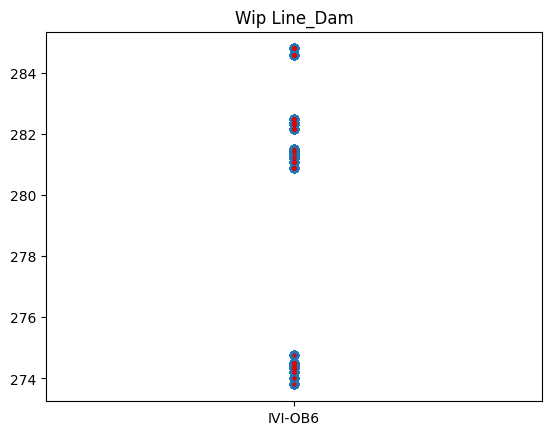

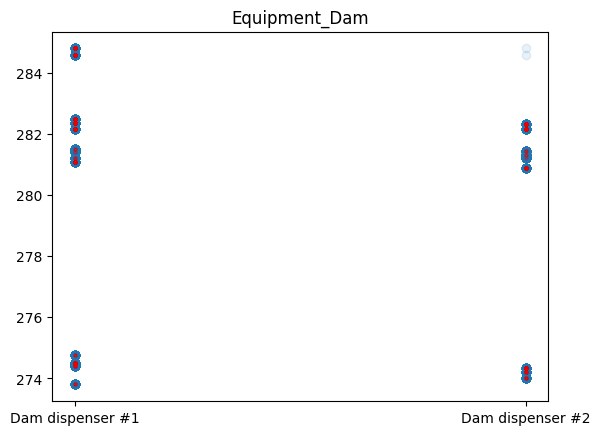

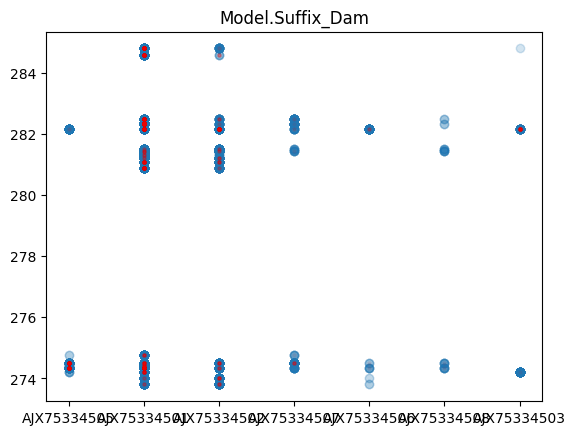

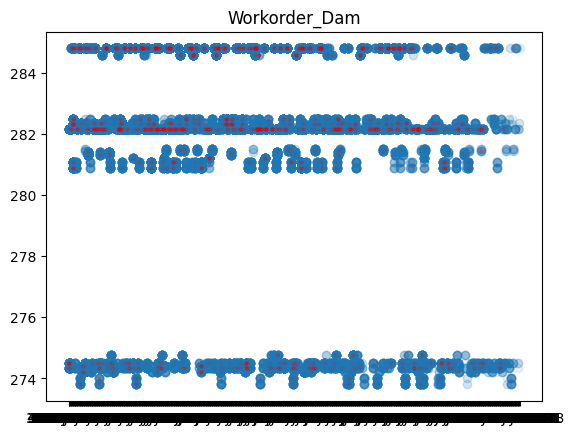

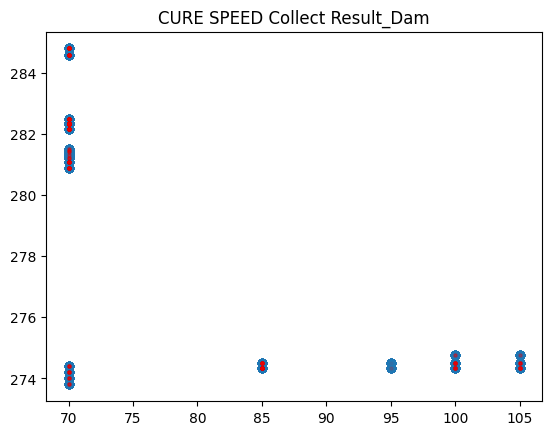

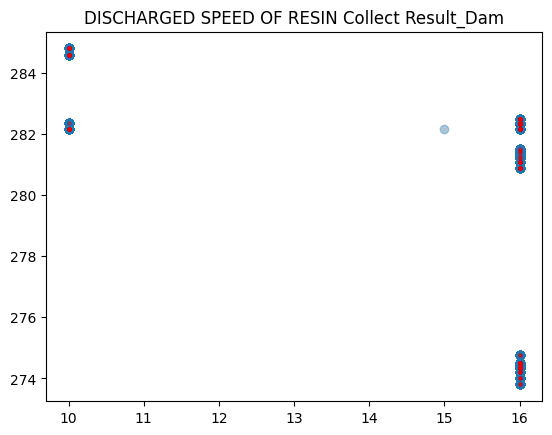

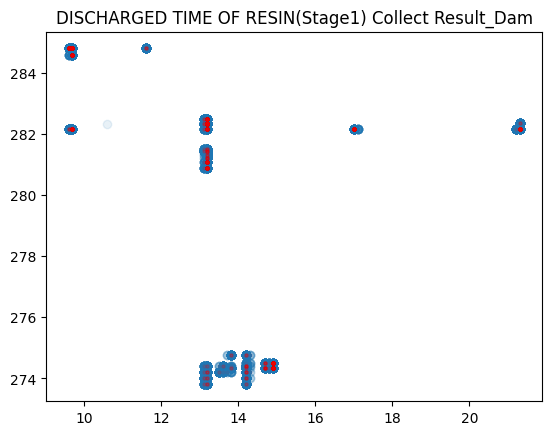

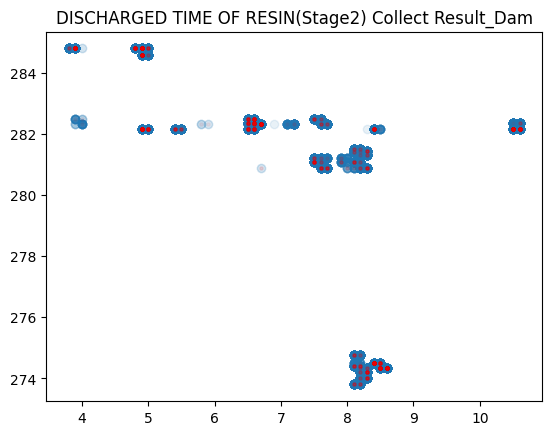

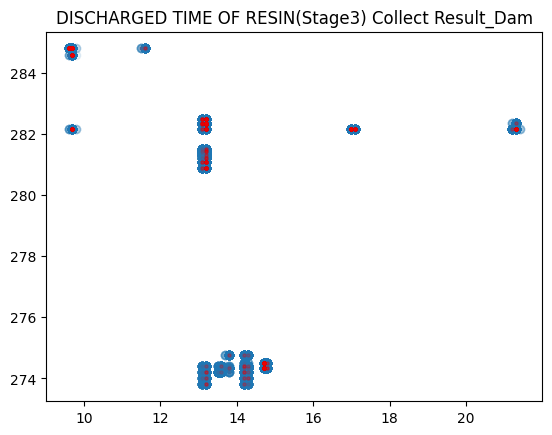

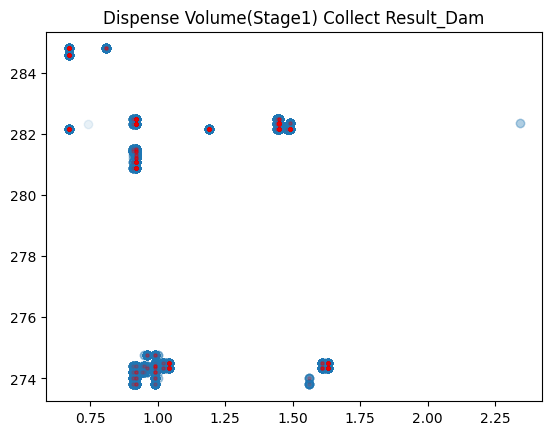

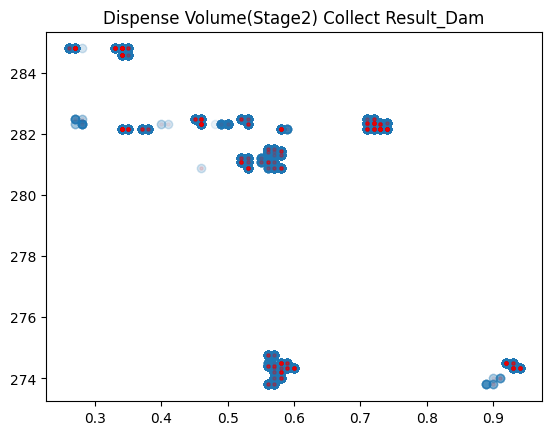

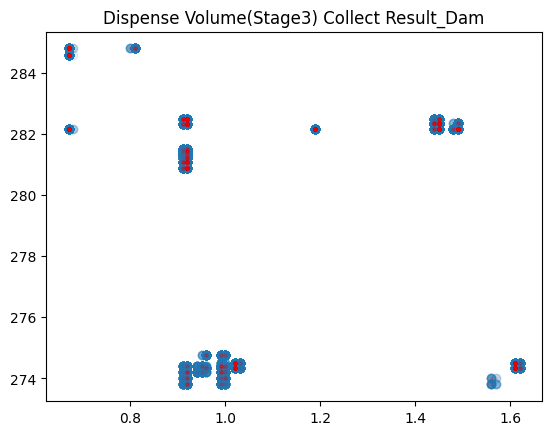

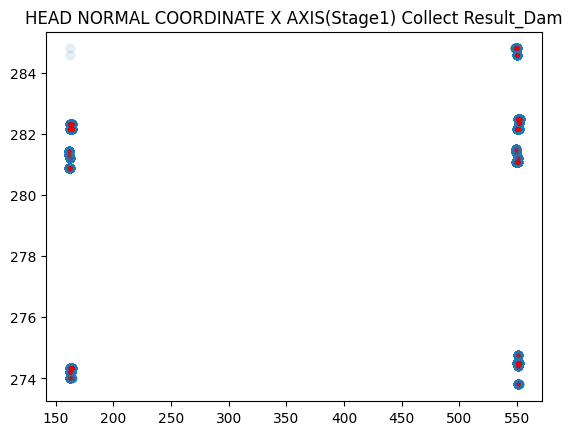

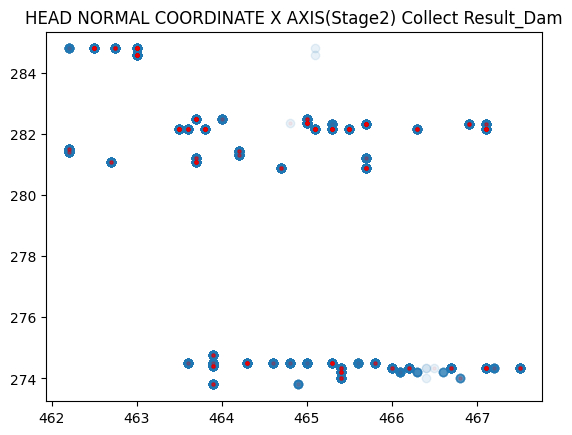

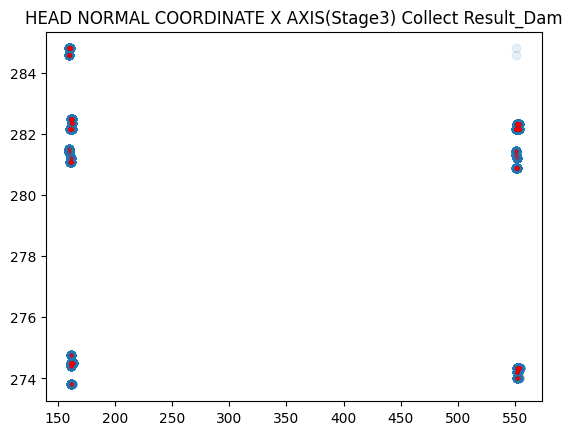

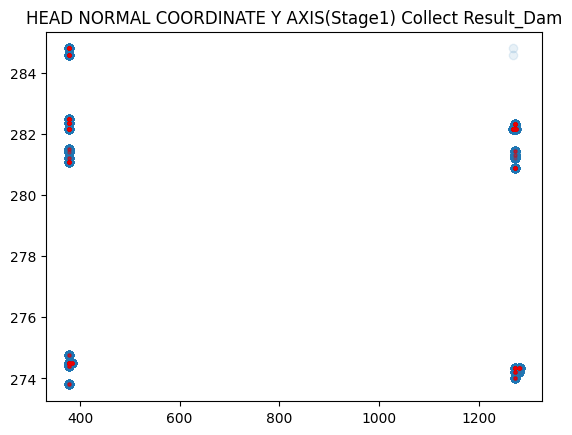

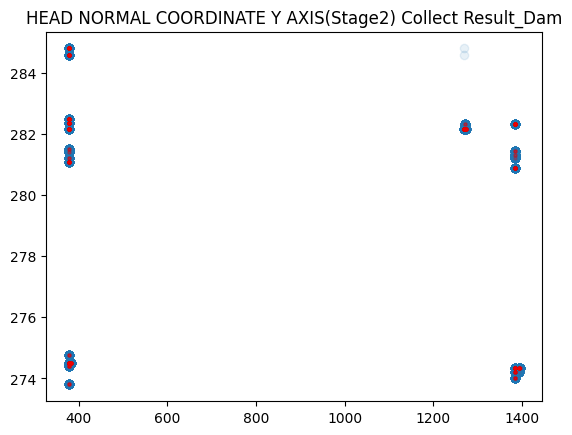

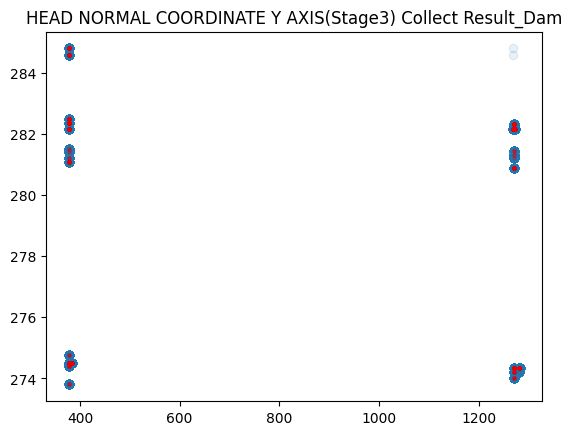

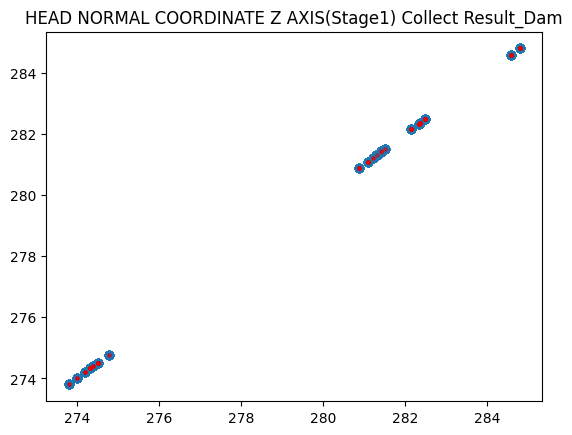

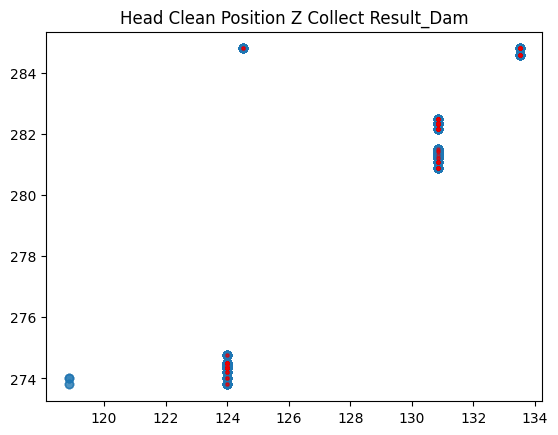

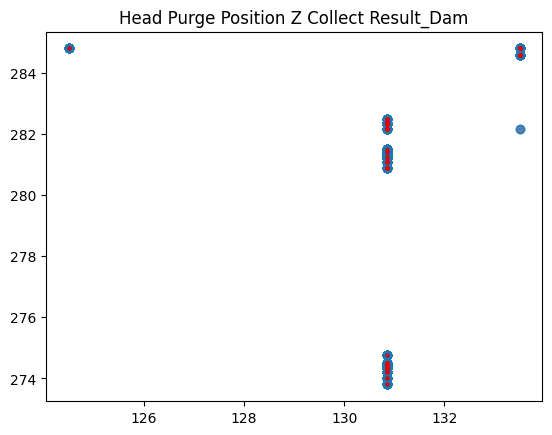

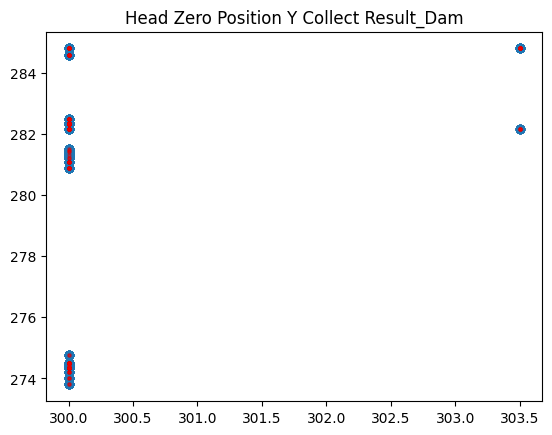

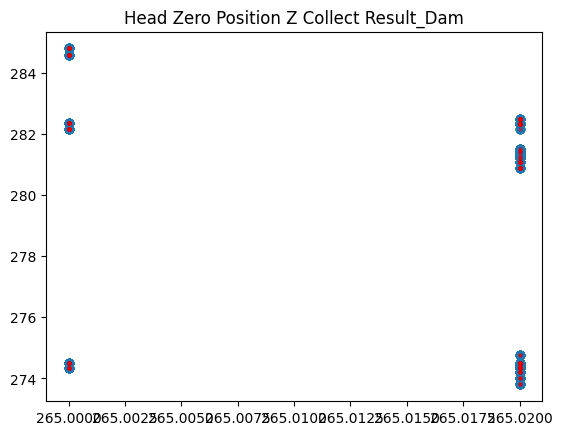

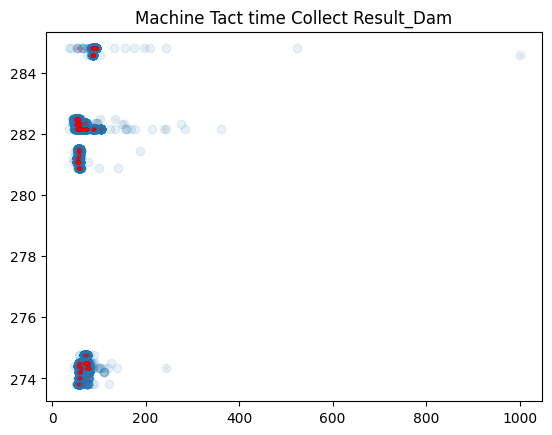

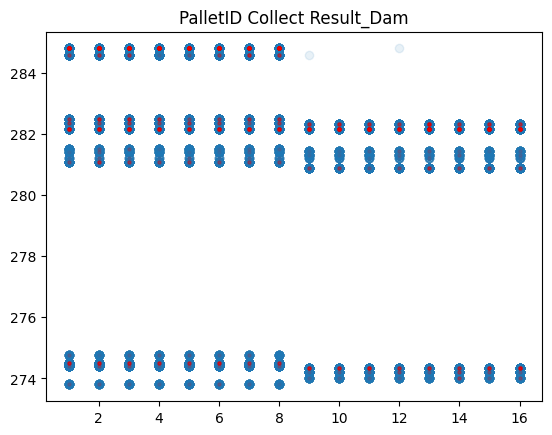

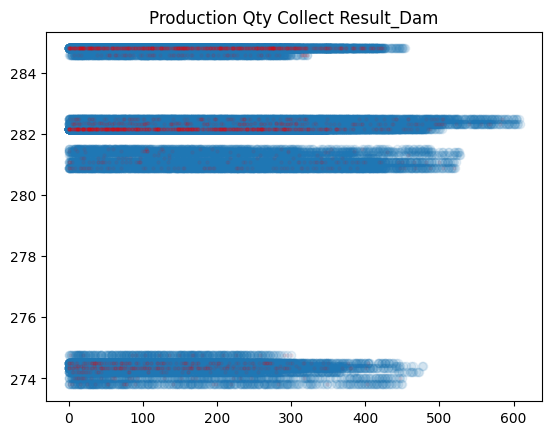

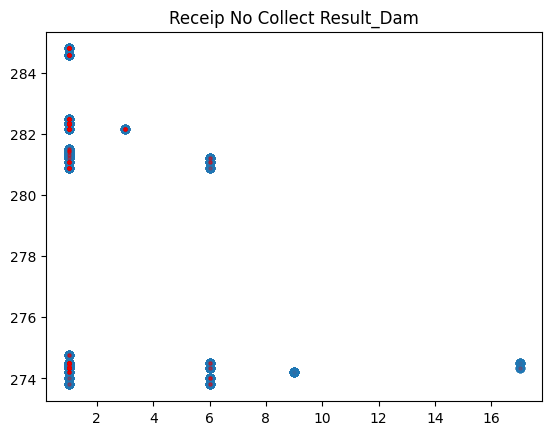

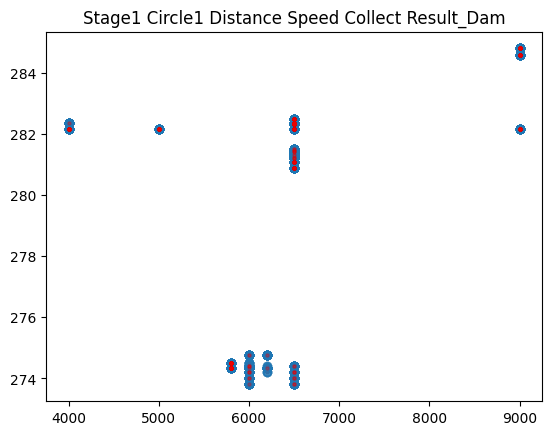

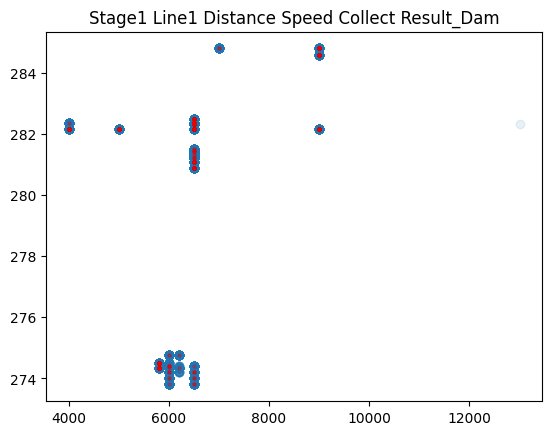

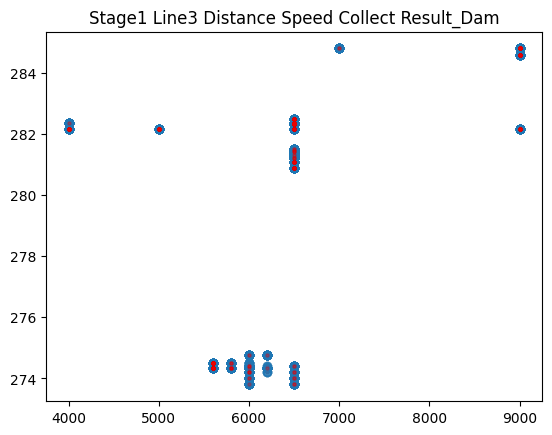

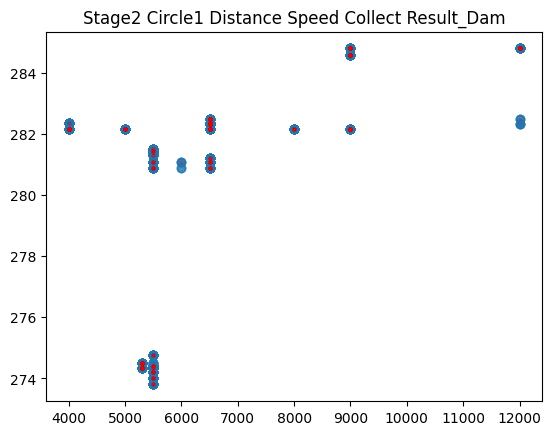

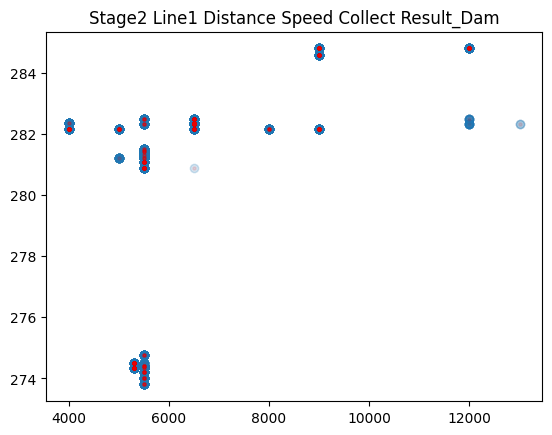

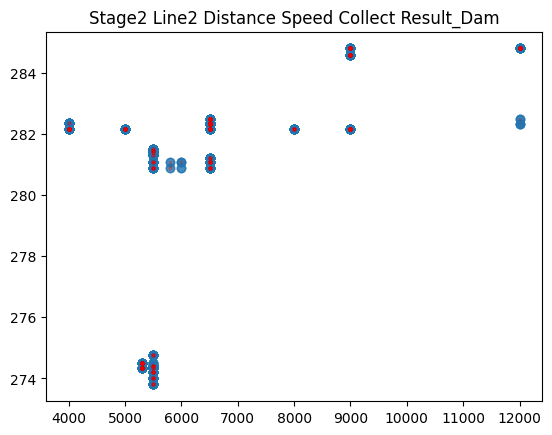

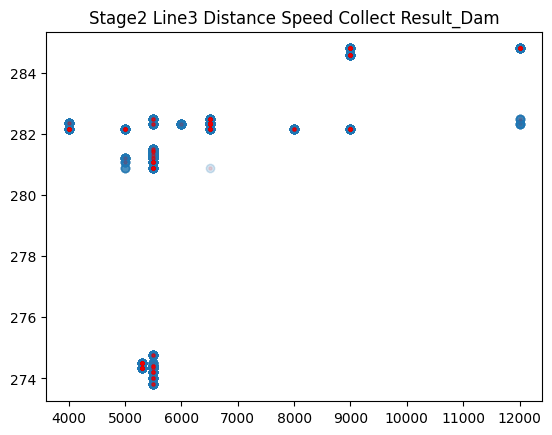

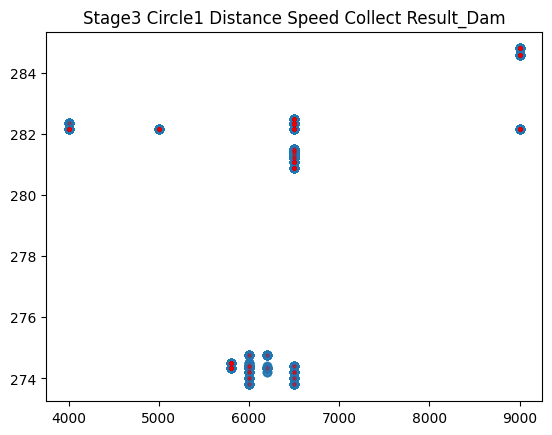

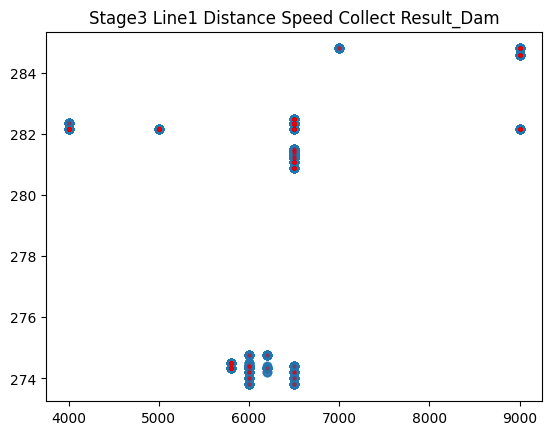

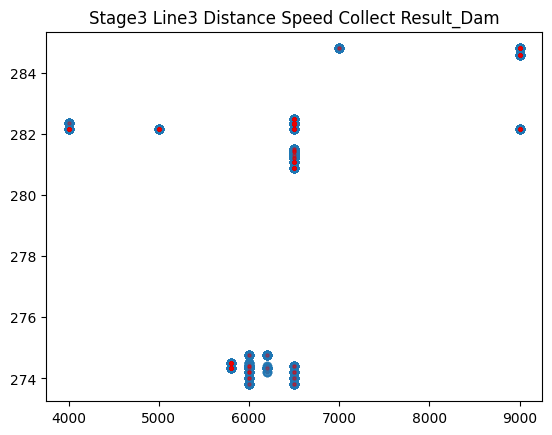

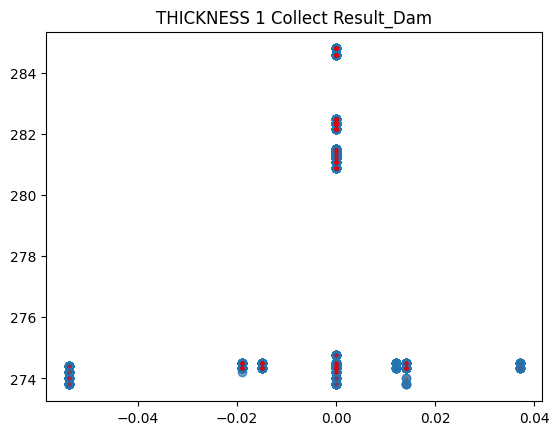

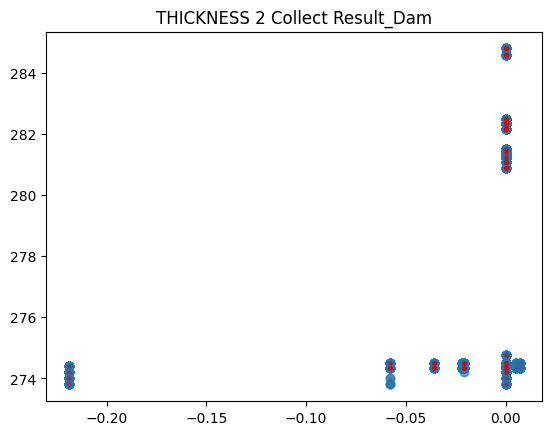

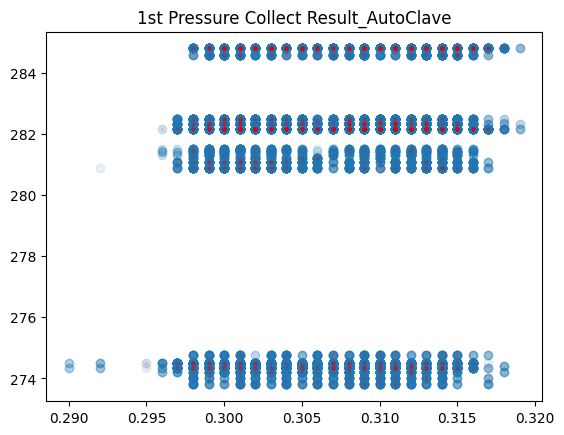

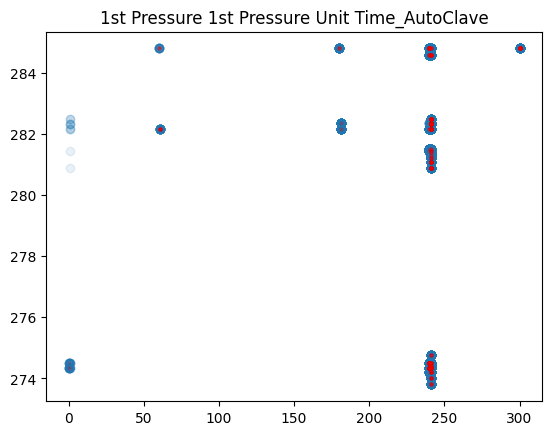

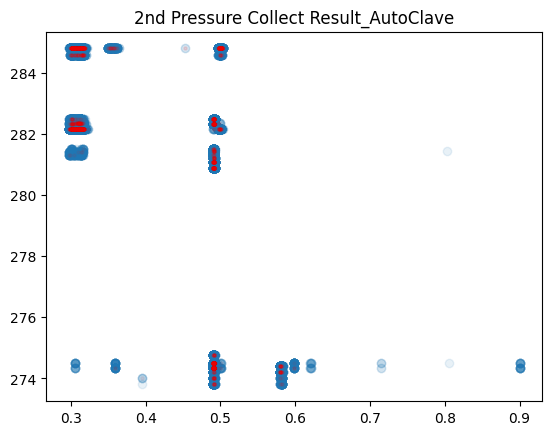

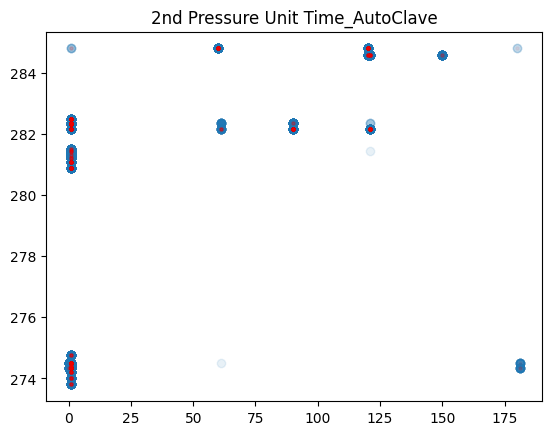

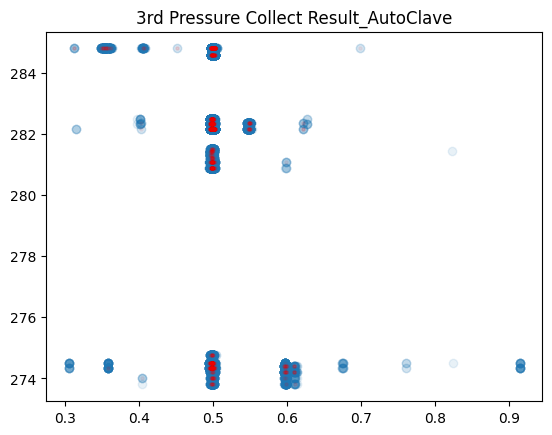

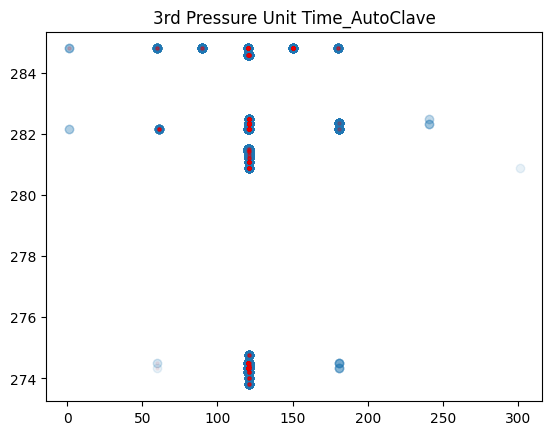

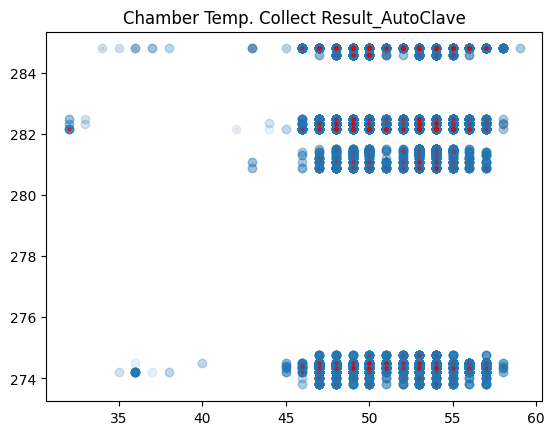

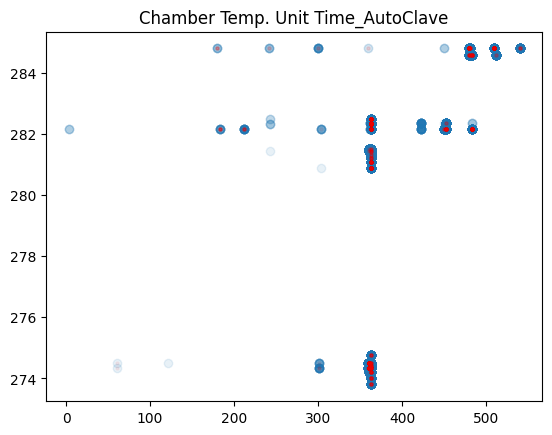

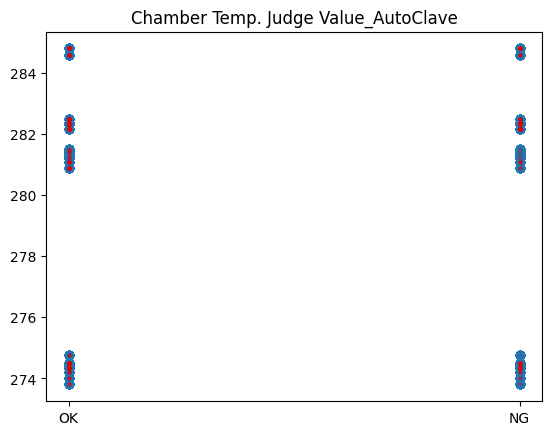

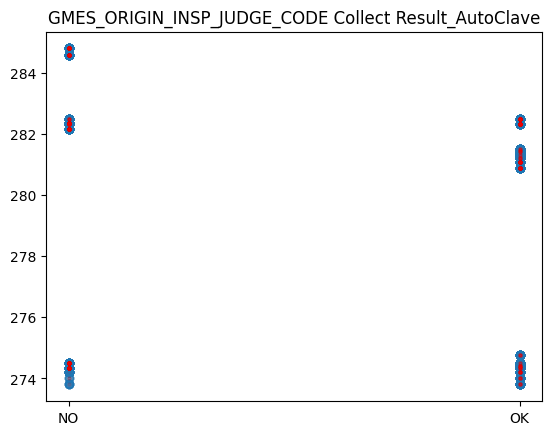

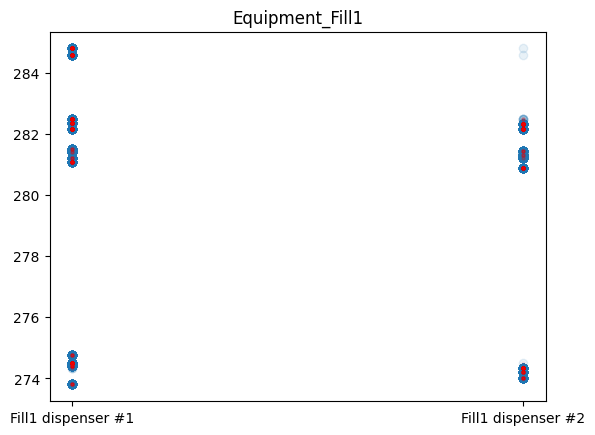

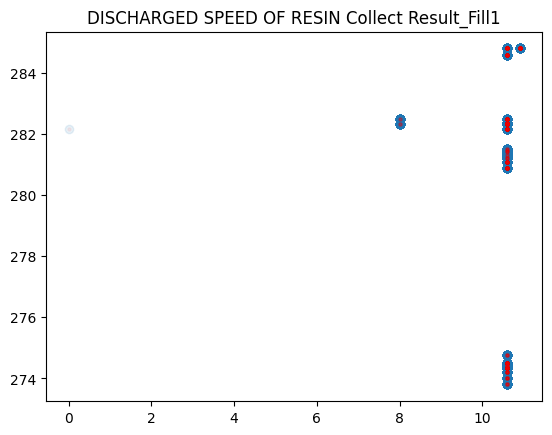

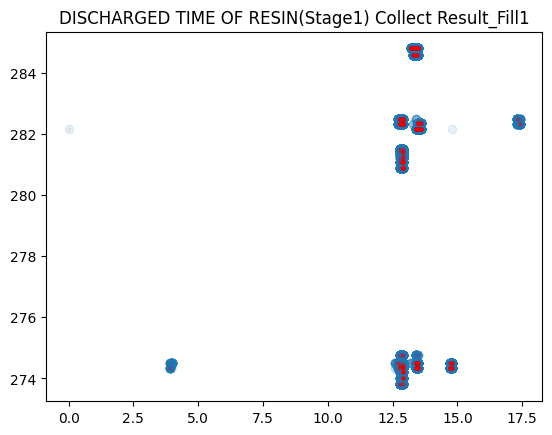

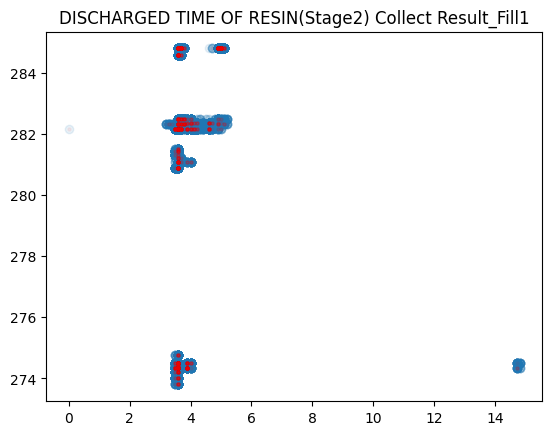

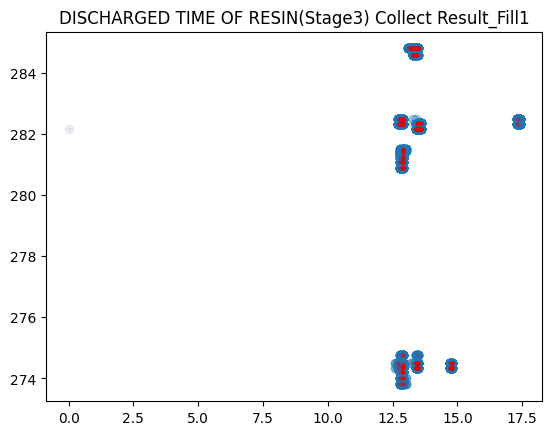

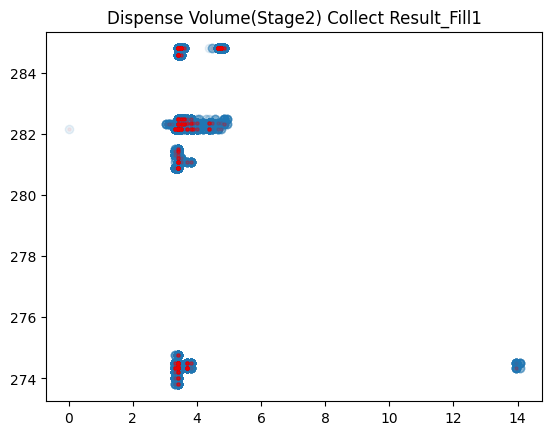

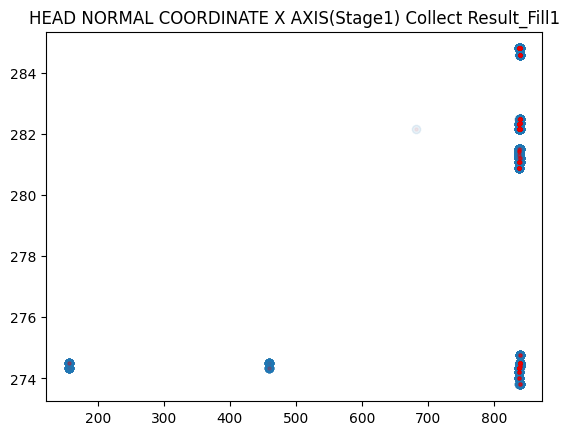

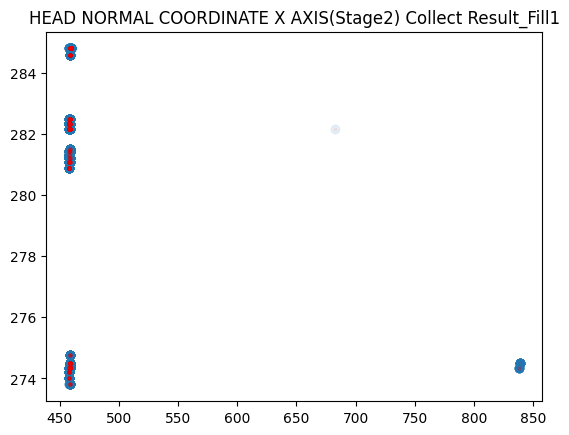

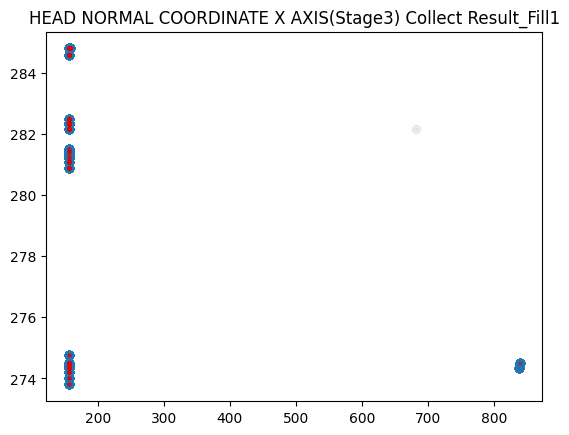

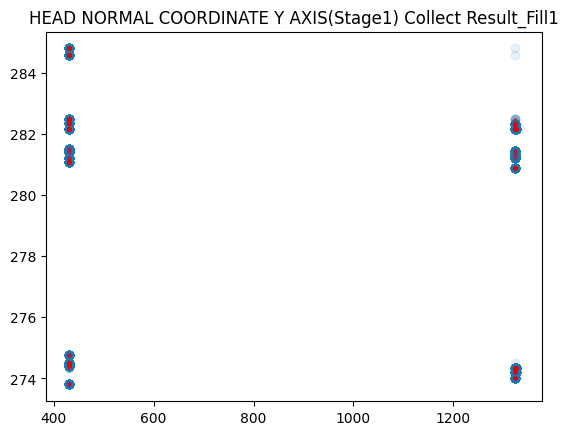

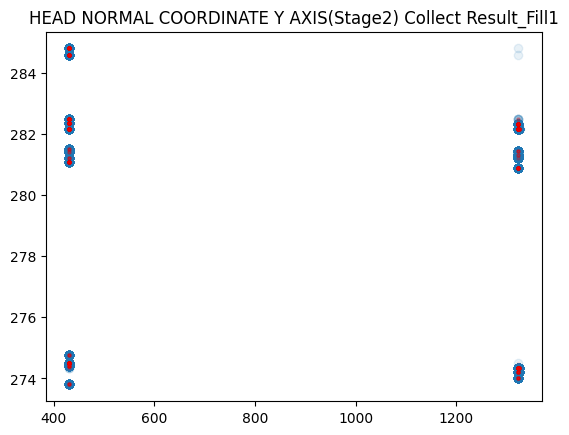

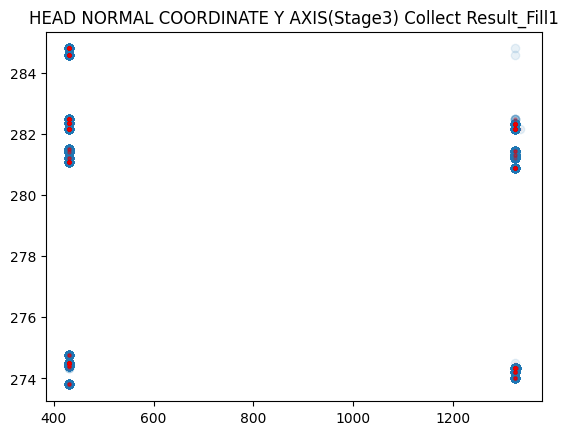

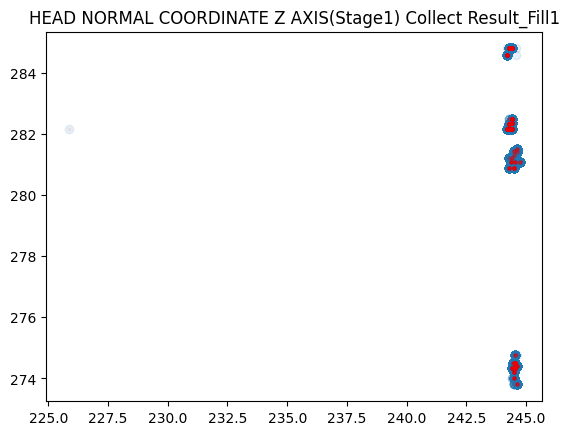

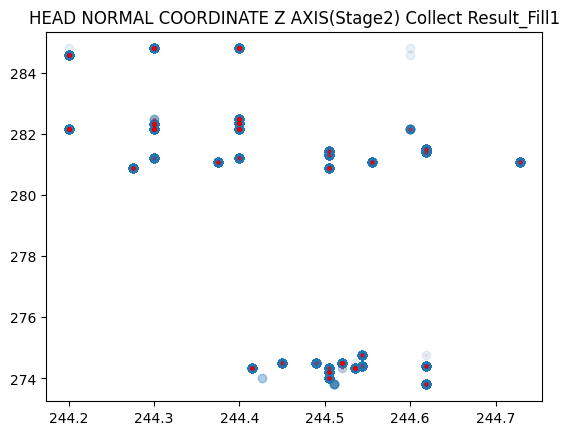

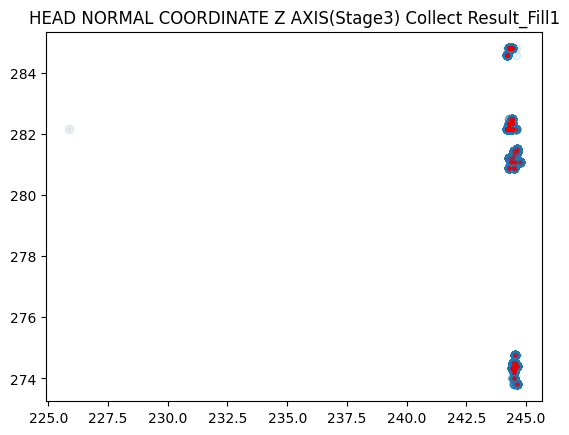

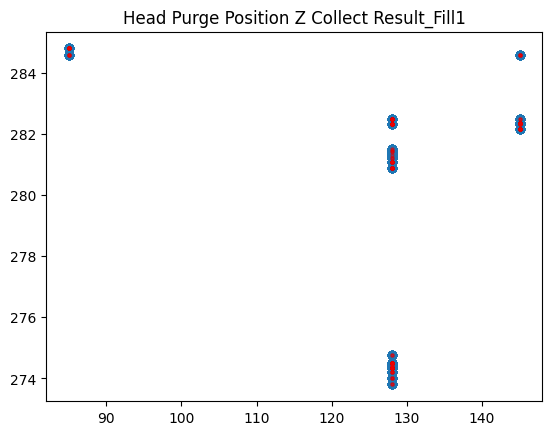

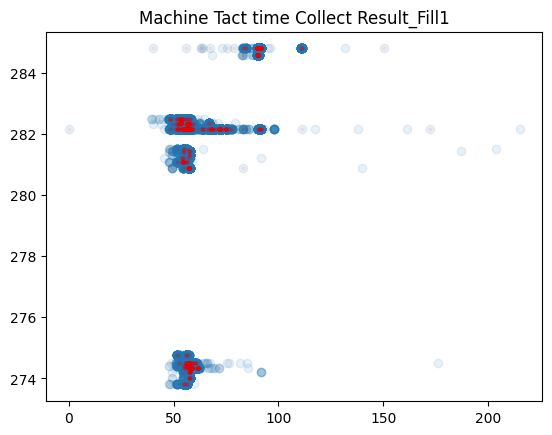

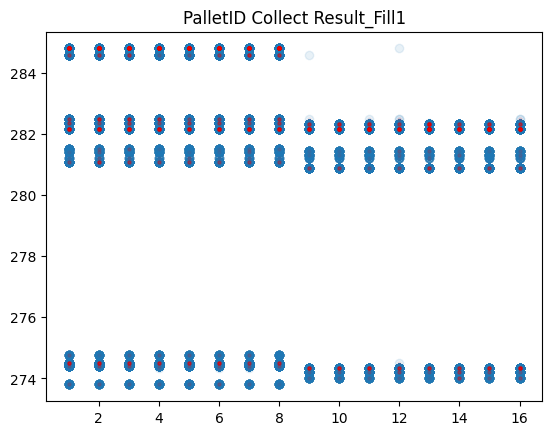

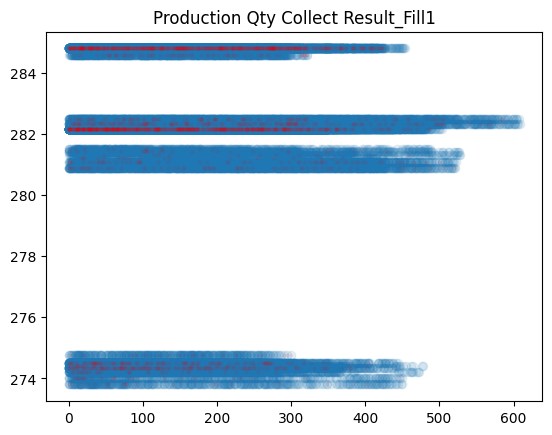

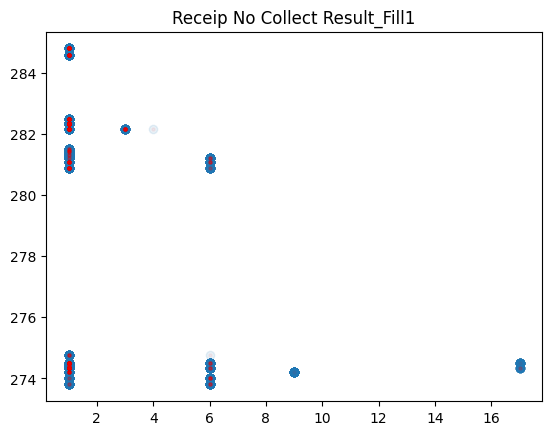

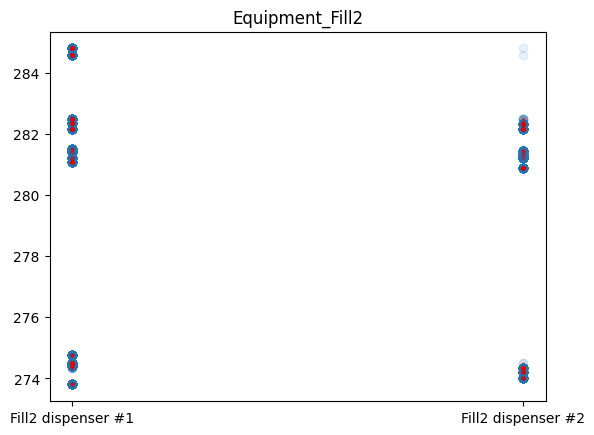

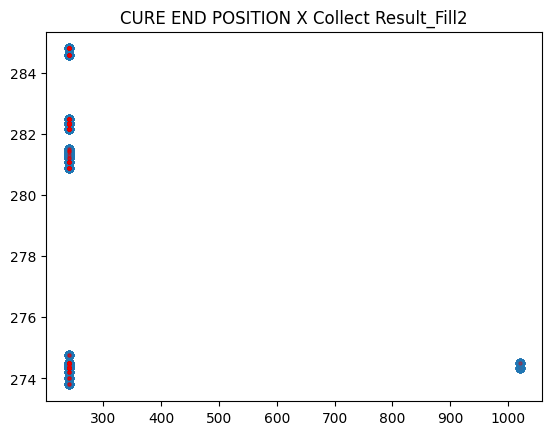

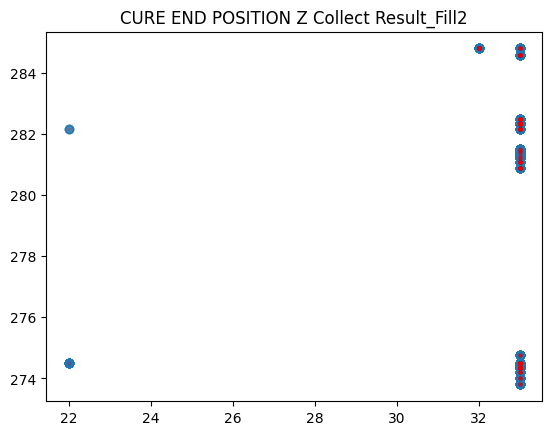

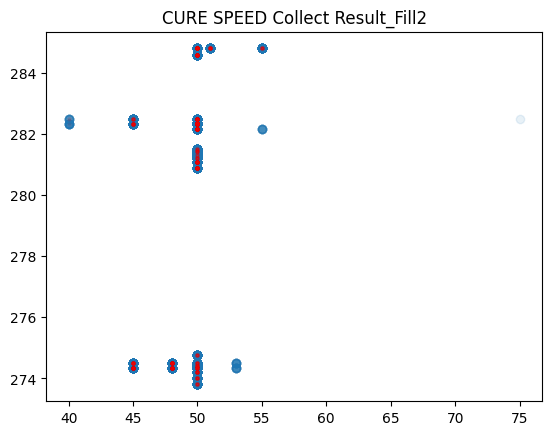

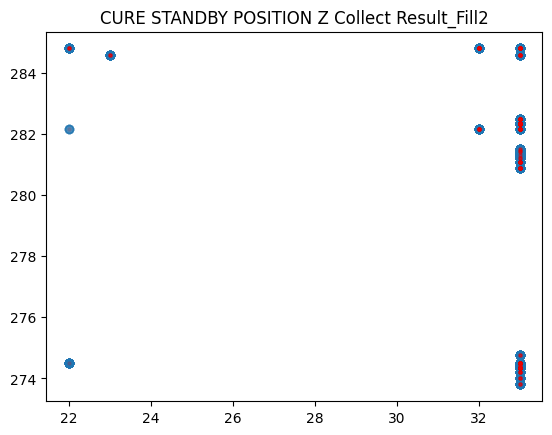

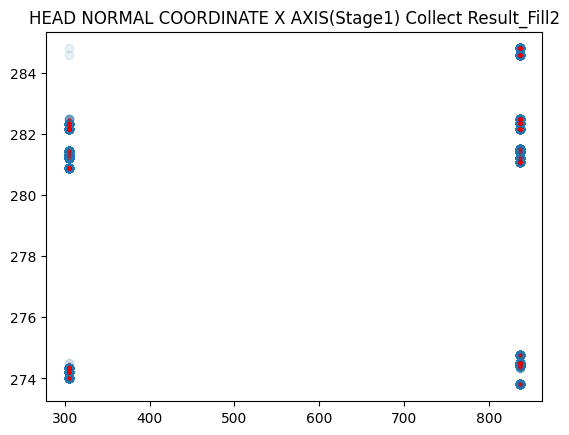

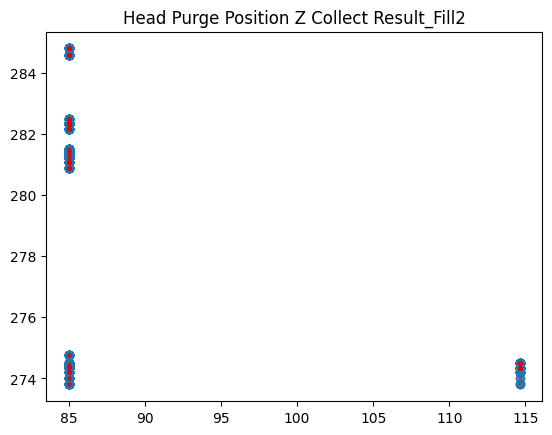

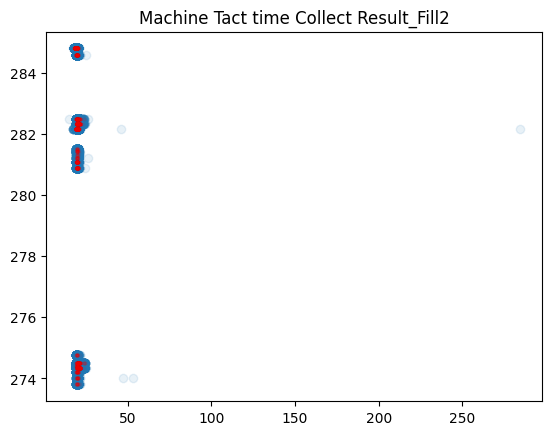

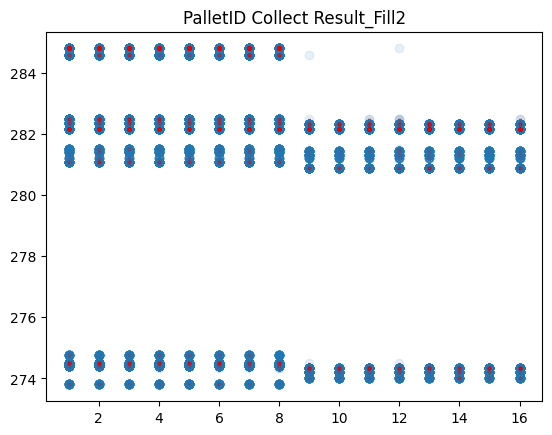

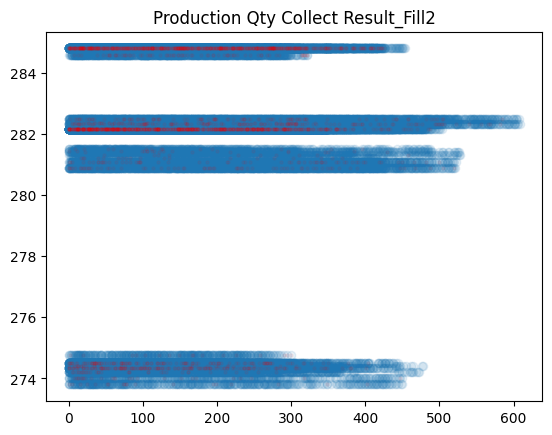

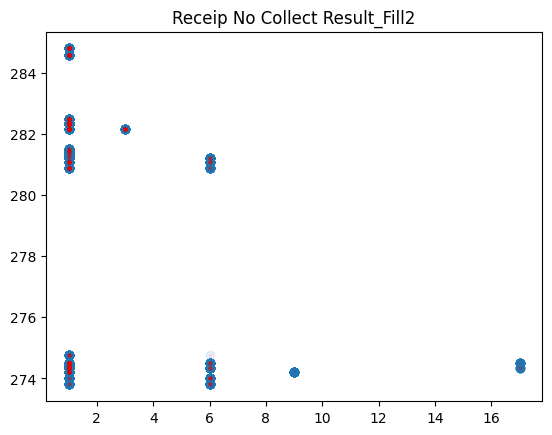

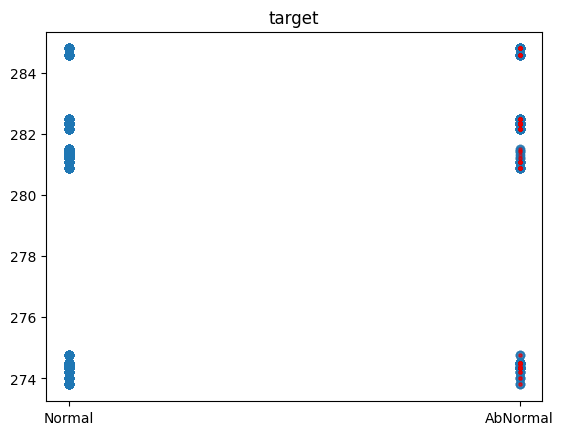

In [1454]:
for col in df[unique_cols].columns:
    try:
        plt.scatter(df[col], df['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'], alpha=0.1)
        plt.scatter(df.loc[df['target']=='AbNormal',col], df.loc[df['target']=='AbNormal', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'], color='r', alpha=0.05, s=5)
        plt.title(col)
        plt.show()
    except:
        continue

In [1530]:
from catboost import CatBoostClassifier, Pool

X_train_col=X_train[unique_cols[:-1]].loc[:,X_train[unique_cols[:-1]].nunique()>1]
col=X_train_col.columns[(~X_train_col.columns.str.contains('Line')&(~X_train_col.columns.str.contains('Circle')))]
# col=X_train_col.columns[(X_train_col.columns.str.contains('Auto'))|(X_train_col.columns.str.contains('Dam'))|(X_train_col.columns.str.contains('Fill1'))]
categorical_features_indices = list(X_train[col].select_dtypes(include=['object']).columns)

# y_resampled의 클래스 비율 계산
class_counts = y_train.value_counts()
total_samples = len(y_train)

# 각 클래스의 가중치 계산 (클래스 수가 많을 경우 대비하여 보통의 방식을 사용)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

class_weights['AbNormal'] = class_weights['AbNormal']/1.7

# CatBoost 모델 정의
model2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=0.5,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=class_weights,  # 계산한 클래스 가중치 적용
    cat_features=categorical_features_indices,
    random_seed=RANDOM_STATE,
    verbose=100
)

# 모델 학습
model2.fit(X_train[col], y_train, eval_set=(X_val[col], y_val), use_best_model=True)

# 기존 모델로 예측 확률 계산
y_pred_proba = model2.predict_proba(X_train[col])[:, 1]

# 낮은 임계값(예: 0.3)을 사용하여 더 많은 하드 네거티브 케이스 선택
threshold = 0.52
hard_negative_cases1 = X_train[(y_train == 'AbNormal') & (y_pred_proba <= threshold)]
hard_negative_labels1 = y_train[(y_train == 'AbNormal') & (y_pred_proba <= threshold)]

hard_negative_cases2 = X_train[(y_train == 'Normal') & (y_pred_proba > threshold)]
hard_negative_labels2 = y_train[(y_train == 'Normal') & (y_pred_proba > threshold)]

# 원본 학습 데이터와 결합
X_train_hard = pd.concat([hard_negative_cases1, hard_negative_cases2])
y_train_hard = pd.concat([hard_negative_labels1, hard_negative_labels2])

model3 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=0.5,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=class_weights,  # 계산한 클래스 가중치 적용
    cat_features=categorical_features_indices,
    random_seed=RANDOM_STATE,
    verbose=100
)

# 모델 재학습
model3.fit(X_train_hard[col], y_train_hard, eval_set=(X_val[col], y_val), use_best_model=True)

0:	learn: 0.0783818	test: 0.0772301	best: 0.0772301 (0)	total: 65.6ms	remaining: 1m 5s
100:	learn: 0.3099675	test: 0.2799997	best: 0.3397863 (1)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.3217454	test: 0.3153062	best: 0.3397863 (1)	total: 20.6s	remaining: 1m 22s
300:	learn: 0.3566477	test: 0.3151452	best: 0.3397863 (1)	total: 29.5s	remaining: 1m 8s
400:	learn: 0.3934430	test: 0.3370465	best: 0.3397863 (1)	total: 38.6s	remaining: 57.7s
500:	learn: 0.4228362	test: 0.3611052	best: 0.3611052 (499)	total: 47.8s	remaining: 47.6s
600:	learn: 0.4424661	test: 0.3640874	best: 0.3675256 (557)	total: 56.8s	remaining: 37.7s
700:	learn: 0.4644993	test: 0.3728176	best: 0.3734199 (676)	total: 1m 5s	remaining: 28s
800:	learn: 0.4756774	test: 0.3772092	best: 0.3821095 (753)	total: 1m 14s	remaining: 18.5s
900:	learn: 0.4888594	test: 0.3766649	best: 0.3821095 (753)	total: 1m 23s	remaining: 9.14s
999:	learn: 0.5000228	test: 0.3766045	best: 0.3821095 (753)	total: 1m 31s	remaining: 0us

bestTest = 0.382109

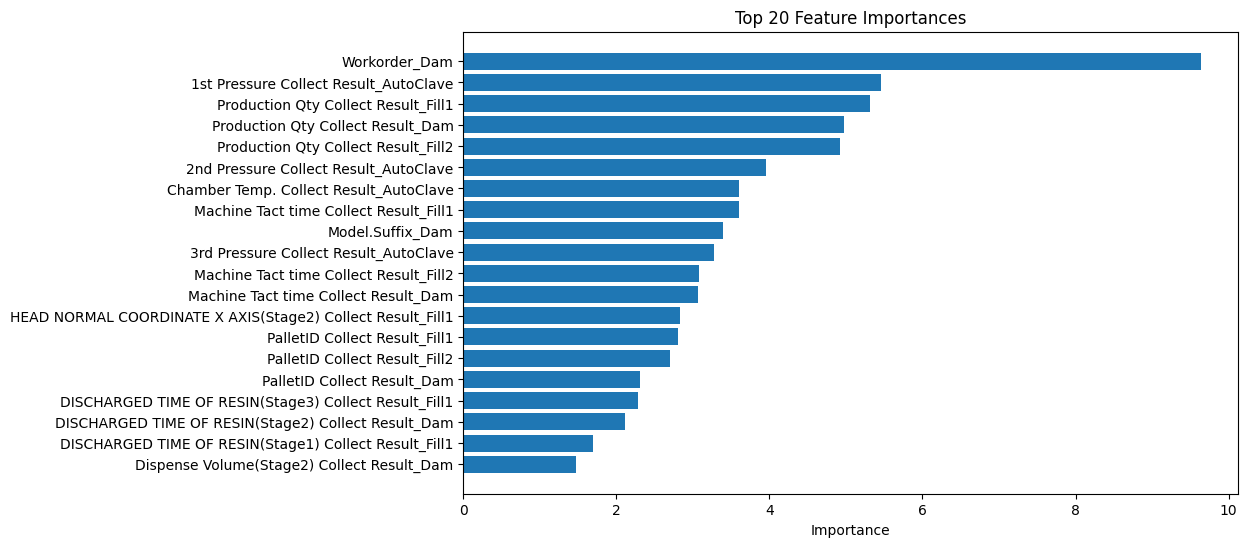

In [1416]:
import matplotlib.pyplot as plt

# 변수 중요도 추출
feature_importances = model2.get_feature_importance()

# 중요도 상위 20개 변수만 추출
top_features = sorted(zip(feature_importances, col), reverse=True)[:20]

# 변수명과 중요도를 각각 리스트로 추출
top_importances = [imp for imp, _ in top_features]
top_names = [name for _, name in top_features]

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_names, top_importances)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 중요도 순으로 내림차순 정렬
plt.show()

In [255]:
import optuna

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 200, 4000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 2),
        'class_weights': [1, trial.suggest_float('class_weights', 5, 20)],
    }
    model = CatBoostClassifier(**param, cat_features=categorical_features_indices, loss_function='Logloss',
    eval_metric='F1', random_seed=RANDOM_STATE, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=50)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, pos_label='AbNormal')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

print("Best trial:")
print(study.best_trial)

[I 2024-08-23 18:03:39,431] A new study created in memory with name: no-name-47fca19b-72c5-4ccd-bb10-8cf47afe487d
[I 2024-08-23 18:03:46,823] Trial 0 finished with value: 0.0 and parameters: {'iterations': 409, 'depth': 3, 'learning_rate': 0.016849816327361683, 'l2_leaf_reg': 8.433741915297187, 'random_strength': 0.9760731922727872, 'bagging_temperature': 1.9314626087325357, 'class_weights': 16.029369074142295}. Best is trial 0 with value: 0.0.
[I 2024-08-23 18:04:01,139] Trial 1 finished with value: 0.0 and parameters: {'iterations': 3421, 'depth': 8, 'learning_rate': 0.008291077804230771, 'l2_leaf_reg': 2.3450586413861494, 'random_strength': 0.7020866231522618, 'bagging_temperature': 0.06266144685008013, 'class_weights': 14.215973873460644}. Best is trial 0 with value: 0.0.
[I 2024-08-23 18:04:08,429] Trial 2 finished with value: 0.0 and parameters: {'iterations': 1053, 'depth': 7, 'learning_rate': 0.005538036686406835, 'l2_leaf_reg': 1.5678540145793969, 'random_strength': 0.62261215

Best trial:
FrozenTrial(number=677, state=1, values=[0.055674518201284794], datetime_start=datetime.datetime(2024, 8, 24, 1, 15, 16, 948028), datetime_complete=datetime.datetime(2024, 8, 24, 1, 16, 28, 848030), params={'iterations': 2377, 'depth': 7, 'learning_rate': 0.0980547869789147, 'l2_leaf_reg': 1.1633890890687262, 'random_strength': 1.1538768908734789, 'bagging_temperature': 0.9678234112163212, 'class_weights': 5.502093962140373}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=4000, log=False, low=200, step=1), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.005, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=2.0, log=False, low=0.5, step=None), 'bagging_temperature': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'class_weights': FloatDistribution(high=

In [391]:
best_params=study.best_params
best_params['class_weights'] = {'Normal': 1, 'AbNormal': study.best_params['class_weights']}

In [392]:
model = CatBoostClassifier(
    **best_params,  # 최적의 파라미터를 적용
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=categorical_features_indices,
    random_seed=RANDOM_STATE,
    verbose=100
)

# 모델 학습
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=300)

# 예측
y_pred = model.predict(X_test)

0:	learn: 0.6049707	test: 0.3979768	best: 0.3979768 (0)	total: 83.5ms	remaining: 3m 18s
100:	learn: 0.7590509	test: 0.4353576	best: 0.4430876 (18)	total: 6s	remaining: 2m 15s
200:	learn: 0.8783939	test: 0.4021425	best: 0.4430876 (18)	total: 11.7s	remaining: 2m 7s
300:	learn: 0.9321250	test: 0.3702040	best: 0.4430876 (18)	total: 17.8s	remaining: 2m 3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.4430875761
bestIteration = 18

Shrink model to first 19 iterations.


In [393]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
cm=confusion_matrix(y_test, y_pred)
print('혼동행렬\n', cm)
p_score=precision_score(y_test, y_pred, pos_label='AbNormal')
r_score=recall_score(y_test, y_pred, pos_label='AbNormal')
f_score=f1_score(y_test, y_pred, pos_label='AbNormal')
print('precision: ', p_score)
print('recall: ', r_score)
print('f1 score: ', f_score)

혼동행렬
 [[ 289  162]
 [3156 4476]]
precision:  0.08388969521044992
recall:  0.6407982261640798
f1 score:  0.14835728952772073


## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [355]:
test_data = pd.read_csv('data/test.csv')

In [ ]:
test=scale(test, scaler,'test')

In [357]:
test_data=test_data[unique_cols[:-1]]
test_data=test_data.loc[:,test_data.nunique()>1]

In [358]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 프레임 생성
scaled_data=test_data.copy()

# 실수형 변수만 선택
numeric_features = test_data.select_dtypes(include=['float64', 'int64'])

# 실수형 변수를 스케일링
scaled_numeric_features = scaler.transform(numeric_features)

# 스케일링된 데이터를 데이터프레임으로 변환
scaled_numeric_df = pd.DataFrame(scaled_numeric_features, index=test_data.index, columns=numeric_features.columns)

# 스케일링된 데이터프레임과 나머지 변수(타겟 포함)를 합침
scaled_data.update(scaled_numeric_df)

test_data=scaled_data.copy()

In [359]:
test_pred=model.predict(test_data)

In [1754]:
index1 = [   64,   562,  1460,  1530,  1892,  2505,  2710,  3457,  3682,  3732,
        4928,  4932,  6092,  7001,  7287,  7666,  7836,  8253,  8898, 10989,
       12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964]
index1

[64,
 562,
 1460,
 1530,
 1892,
 2505,
 2710,
 3457,
 3682,
 3732,
 4928,
 4932,
 6092,
 7001,
 7287,
 7666,
 7836,
 8253,
 8898,
 10989,
 12439,
 12585,
 12844,
 14756,
 15180,
 15406,
 15811,
 15964]

In [1755]:
# 특정 값들을 가진 행만 추출
values_to_extract = [4.3, 4.4, 4.5, 4.8, 14.8]
index2 = test_data[test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'].isin(values_to_extract)].index

In [1756]:
index3 = test_data[test_data['Workorder_Dam']=='4C1XH474-1'].index

### 제출 파일 작성


In [334]:
# test_pred=pd.Series(test_pred).map({0: 'Normal', 1: 'AbNormal'})

In [360]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [361]:
df_sub.target.value_counts()

target
Normal      16009
AbNormal     1352
Name: count, dtype: int64

In [369]:
df_sub.target.value_counts()

target
Normal      15988
AbNormal     1373
Name: count, dtype: int64

In [367]:
df_sub.loc[index1, 'target'] = 'AbNormal'

In [368]:
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
